# Importing libraries

### Importing all libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import cv2
import json

from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer

# from langid.langid import LanguageIdentifier, model
# from langid.langid import set_languages
import time

from nltk.stem import WordNetLemmatizer

In [223]:
## define date & time to print-out files

from datetime import date, datetime

def date_time():
    today = date.today()
    now = datetime.now() 

    return today.strftime("%Y%m%d") +'_'+ now.strftime("%H%M")


In [3]:
my_seed = 123

# Defining functions

### Feature engineering: title_descr
[ ] does the function need to have a return df?

In [5]:
def concatenate_variables(df, col1, col2, nans_to, separator, concat_col_name, to_drop = None):
    '''
    Replace NaNs in col1 and col2 with string nans_to
    Concatenate col1 and col2 using a separator string separator
    Drop columns if specified by to drop (list of columns)
    save in a new variable named by concat_col_name
    '''
    
    ## Replace NaN's in description with empty string
    df[col1] = df[col1].fillna(nans_to)
    df[col2] = df[col2].fillna(nans_to)

    ## Concatenate col1 with col2
    df[concat_col_name] = df[col1] + separator + df[col2]
    
    ## drop columns
    if to_drop is not None:
        for col in to_drop:
            df.drop(col, axis = 1, inplace = True)


### HTML parsing 

In [6]:
def html_parsing(df, col_to_parse, verbose = False):
    '''
    HTML parse and lower case text content in col_to_parse
    '''
    t0 = time.time()

    df[col_to_parse] = [BeautifulSoup(text).get_text().lower() for text in df.loc[:,col_to_parse]]

    t1 = time.time()
    
    if verbose: 
        print(f"Column '{col_to_parse}' has been successfully HTML parsed")
        print("HTML parsing takes %0.2f seconds" %(t1-t0))

### Feature engineering: Tokenization & Lemmatization

In [7]:

def get_lemmatized_tokens(df, col_to_tokenize, tokenizer, tokenized_col, lemmatizer, uniques = False, verbose = True):
    '''
    For each row creates a list of tokens obtained from 'col_to_tokenize' column by tokenizing the text.
    Then lemmatize each word in the list, for each row.
    If unique = True, remove duplicated from each list of lemmas using set(). Keep the order of the words in list.
    Store list of lemmas in a new variable 'tokenized_col'
    '''    
    
    t0 = time.time()
    
    all_token_list = [tokenizer.tokenize(text) for text in df.loc[:,col_to_tokenize]]
    all_lemmatized_list = [ [lemmatizer.lemmatize(t) for t in token_list] for token_list in all_token_list ]

    if uniques :    
        df[tokenized_col] = [sorted( set(lemma_list), key=lemma_list.index ) for lemma_list in all_lemmatized_list ]
    else:    
        #df[tokenized_col] = [tokenizer.tokenize(text) for text in df.loc[:,col_to_tokenize]]
        df[tokenized_col] = all_lemmatized_list

    t1 = time.time()
    
    if verbose:
        print(f"Column '{col_to_tokenize}' has been successfully tokenized")
        print("Tokenization + Lemmatization takes %0.2f seconds" %(t1-t0))
    

### Get Language

In [8]:
def get_language(df, text_col, correct = False, verbose = False):
    
    ## Main language identfication
    ## instantiate identifier to get probabilities
    identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
    
    ## identify language
    time_0 = time.time()

    languages_probas = [identifier.classify(text) for text in df[text_col]]
    
    time_1 = time.time()
        
    if correct:
        ## restricted identifier
        identifier_2 = LanguageIdentifier.from_modelstring(model, norm_probs=True)
        identifier_2.set_languages(langs=['fr','en'])
        
        for i in range(len(languages_probas)):    
            if languages_probas[i][1] < 0.9999:
                languages_probas[i] = identifier_2.classify(df.loc[i,'title_descr'])
                
    time_2 = time.time()
    
    if verbose:
        print("Main language detection takes %0.2f minutes" %((time_1 - time_0)/60) )
        if correct:
            print("Language detection correction takes %0.2f seconds" %(time_2 - time_1) )

    
    language_dict = {'language' : list(np.array(languages_probas)[:,0]),
            'lan_prob' : [float(p) for p in np.array(languages_probas)[:,1]]}
    
    df_languages = pd.DataFrame(language_dict)
    
    return df_languages
    

In [9]:

# def detect_language(df, text_col, correct = False, verbose = False):
    
#     ## Main language identfication
#     ## instantiate identifier to get probabilities
#     identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
    
#     ## identify language
#     time_0 = time.time()

#     df[['language', 'lang_prob']] = [identifier.classify(text) for text in df[text_col]]

    
#     time_1 = time.time()
        
#     if correct:
#         ## restricted identifier
#         identifier_2 = LanguageIdentifier.from_modelstring(model, norm_probs=True)
#         identifier_2.set_languages(langs=['fr','en'])
        
#         for i in range(len(df)):    
#             if df.loc[i,'lang_prob'] < 0.9999:
#                 df.loc[i,['language', 'lang_prob']] = identifier_2.classify(df.loc[i,'title_descr'])
                
#     time_2 = time.time()
    
#     if verbose:
#         print("Main language detection takes %0.2f minutes" %((time_1 - time_0)/60) )
#         if correct:
#             print("Language detection correction takes %0.2f seconds" %(time_2 - time_1) )

    

### Remove stop words from tokens

In function **import_stop_words**:  
- [x] Inlude other languages (if included in spacy)  

In function **remove_stop_words**:  
  > Option-1: Using list comprehension takes 76 seconds for the whole dataframe. DO NOT USE  
  > Option-2: Using a for loop to iterate the dataframe takes 39 seconds for the whole dataframe. 

- [x] Should we use set(tokens) at the end ? to get unique tokens ?
    > Lemmatized tokens are already uniques

In [10]:
def import_stop_words(language):
    '''
    Import list of stop words from the indicated language.
    If language is not in the list of the top 4 languages, use FR+EN by default.
    '''
    
    # top 4 languages in dataset
    available = ['fr', 'en', 'de', 'it']
    
    if language == 'fr':
        from spacy.lang.fr.stop_words import STOP_WORDS as stop_fr
        return list(stop_fr)
        
    elif language == 'en':
        from spacy.lang.en.stop_words import STOP_WORDS as stop_en
        return list(stop_en)

    elif language == 'de':
        from spacy.lang.de.stop_words import STOP_WORDS as stop_de
        return list(stop_de)

    elif language == 'it':
        from spacy.lang.it.stop_words import STOP_WORDS as stop_it
        return list(stop_it)

    else:
        from spacy.lang.fr.stop_words import STOP_WORDS as stop_fr
        from spacy.lang.en.stop_words import STOP_WORDS as stop_en
        return list(stop_fr) + list(stop_en)
    

In [11]:
def remove_stop_words(df, col_to_clean, col_result, col_language, verbose = False):
    '''
    Remove the stop words from each token list in df[col_to_clean] according to the datected language df['language']
    Store the cleaned token list in a new variable df[col_result]
    If col_result result does not exist in dataframe, intialize with empty strings (object dtype)
    '''
    ## Option - 1: list comprehension 
#     t0 = time.time()
#     new_name = col_result + '_O1'
#     df[new_name] = [ [token for token in token_list if token not in import_stop_words(language)] for token_list, language in zip(df.tokens,df.language)]
#     t1 = time.time()


    ## Option - 2: iterate over the dataframe
    t2 = time.time()
    
    new_name = col_result #+ '_O2'
    if new_name not in df.columns:
        df[new_name] = ''  # initilize col as 'object' type
    
    for i, token_list, language in zip(df.index, df[col_to_clean], df[col_language]):
    
        stop_words = import_stop_words(language)        
        df.at[i, new_name] = [token for token in token_list if token not in stop_words]
    
    t3 = time.time()
        
    if verbose:
        #print("time taken with comprehension list %0.f seconds" %(t1-t0))
        print("time taken with for loop list %0.f seconds" %(t3-t2))

### Get token length

In [12]:
def get_token_length(df, col_with_tokens, col_with_length, verbose = False):
    '''
    Creates a new variable measuring the number of tokens in column col_with_tokens
    '''
    t0 = time.time()
    
    df[col_with_length] = [len(token_list) for token_list in df[col_with_tokens] ]
    
    t1 = time.time()
    
    if verbose:
        print("token count takes %0.2f seconds" %(t1-t0))

# Data Processing

### importing all data
[ ] Do we merge df_X or df_y or not ?  
[ ] Drop column 'target' in product_class if problematic.  

In [4]:
## features and target
df_X = pd.read_csv('./datasets/X_train_update.csv', index_col = 0)
df_y = pd.read_csv('./datasets/Y_train_CVw08PX.csv', index_col = 0)

## merge feature and target ? ---> it maybe better for preprocessing, then separate for model training
df = pd.concat([df_y,df_X], axis = 1)

## class labels
product_class = pd.read_csv('./datasets/product_class.csv', sep = ';')


In [9]:
print(type(df_X))
display(df_X.head())

print(type(df_y))
display(df_y.head())

<class 'pandas.core.frame.DataFrame'>


,designation,description,productid,imageid
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786


<class 'numpy.ndarray'>


,prdtypecode
0,10
1,2280
2,50
3,1280
4,2705


### Rename variables

In [13]:
## Rename th# Importing data and librariese variable 'designation' by 'title' which is more convenient
df.rename({'designation':'title'}, axis = 1, inplace = True)
df.head()

,prdtypecode,title,description,productid,imageid
0,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,2705,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786


### Feature engineering: title_descr

In [14]:
concatenate_variables(df, 'title', 'description', nans_to = '', separator ='\n', concat_col_name = 'title_descr', \
                      to_drop = None)
df.head()

,prdtypecode,title,description,productid,imageid,title_descr
0,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,,3804725264,1263597046,Olivia: Personalisiertes Notizbuch / 150 Seite...
1,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,,436067568,1008141237,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...
2,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,Grand Stylet Ergonomique Bleu Gamepad Nintendo...
3,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...,,50418756,457047496,Peluche Donald - Europe - Disneyland 2000 (Mar...
4,2705,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,La Guerre Des Tuques\nLuc a des id&eacute;es d...


**Drop redundant variables: Title & Description**

In [15]:
df.drop(['title','description'], axis = 1, inplace = True)

df.head()

,prdtypecode,productid,imageid,title_descr
0,10,3804725264,1263597046,Olivia: Personalisiertes Notizbuch / 150 Seite...
1,2280,436067568,1008141237,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...
2,50,201115110,938777978,Grand Stylet Ergonomique Bleu Gamepad Nintendo...
3,1280,50418756,457047496,Peluche Donald - Europe - Disneyland 2000 (Mar...
4,2705,278535884,1077757786,La Guerre Des Tuques\nLuc a des id&eacute;es d...


### HTML parse & lower case

In [16]:
html_parsing(df, 'title_descr', verbose = True)

C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


Column 'title_descr' has been successfully HTML parsed
HTML parsing takes 20.54 seconds


In [17]:
df.head()

,prdtypecode,productid,imageid,title_descr
0,10,3804725264,1263597046,olivia: personalisiertes notizbuch / 150 seite...
1,2280,436067568,1008141237,journal des arts (le) n° 133 du 28/09/2001 - l...
2,50,201115110,938777978,grand stylet ergonomique bleu gamepad nintendo...
3,1280,50418756,457047496,peluche donald - europe - disneyland 2000 (mar...
4,2705,278535884,1077757786,la guerre des tuques\nluc a des idées de grand...


### Tokenize & Lemmatize text
* Tokenize title_descr
* Lematize token lists
* if uniques = True, get the unique lematized tokens (no duplicates). Keeps the order.

- [x] I can directly use a tokenizer that keeps only word of more than 2 characters : tokenizer = RegexpTokenizer(r"\w{3,}')

In [18]:
tokenizer = RegexpTokenizer(r'\w{3,}')
lemmatizer = WordNetLemmatizer()

get_lemmatized_tokens(df, 'title_descr', tokenizer, 'lemma_tokens', lemmatizer, uniques = True)

Column 'title_descr' has been successfully tokenized
Tokenization + Lemmatization takes 28.26 seconds


In [19]:
df.head()

,prdtypecode,productid,imageid,title_descr,lemma_tokens
0,10,3804725264,1263597046,olivia: personalisiertes notizbuch / 150 seite...,"[olivia, personalisiertes, notizbuch, 150, sei..."
1,2280,436067568,1008141237,journal des arts (le) n° 133 du 28/09/2001 - l...,"[journal, de, art, 133, 2001, son, marche, sal..."
2,50,201115110,938777978,grand stylet ergonomique bleu gamepad nintendo...,"[grand, stylet, ergonomique, bleu, gamepad, ni..."
3,1280,50418756,457047496,peluche donald - europe - disneyland 2000 (mar...,"[peluche, donald, europe, disneyland, 2000, ma..."
4,2705,278535884,1077757786,la guerre des tuques\nluc a des idées de grand...,"[guerre, de, tuques, luc, idées, grandeur, veu..."


### Feature engineering: get language
* Language detection takes about 5 mins.  DO NOT RE DO IT IF NOT NEEDED.


In [58]:

language_df = get_language(df, 'title_descr', correct = True, verbose = True)


NameError: name 'LanguageIdentifier' is not defined

**Save detected languages**

In [ ]:
write = False

if write:    
    filename = 'df_languages_probas' + date_time() + '.csv'
    
    language_df.to_csv(filename, header=True, index=False)
    print(filename)

**Load previously detected languages**

In [20]:
read = True
if read:
    filename = 'df_languages_probas_20230731' + '.csv'
    
    df_languages = pd.read_csv(filename)
    display(df_languages.head())

,language,lan_prob
0,de,1.0
1,fr,1.0
2,fr,1.0
3,fr,1.0
4,fr,1.0


In [21]:
## concatenate to main dataframe
df = pd.concat([df, df_languages], axis = 1)
df.head()

,prdtypecode,productid,imageid,title_descr,lemma_tokens,language,lan_prob
0,10,3804725264,1263597046,olivia: personalisiertes notizbuch / 150 seite...,"[olivia, personalisiertes, notizbuch, 150, sei...",de,1.0
1,2280,436067568,1008141237,journal des arts (le) n° 133 du 28/09/2001 - l...,"[journal, de, art, 133, 2001, son, marche, sal...",fr,1.0
2,50,201115110,938777978,grand stylet ergonomique bleu gamepad nintendo...,"[grand, stylet, ergonomique, bleu, gamepad, ni...",fr,1.0
3,1280,50418756,457047496,peluche donald - europe - disneyland 2000 (mar...,"[peluche, donald, europe, disneyland, 2000, ma...",fr,1.0
4,2705,278535884,1077757786,la guerre des tuques\nluc a des idées de grand...,"[guerre, de, tuques, luc, idées, grandeur, veu...",fr,1.0


**Drop language probas if not needed**

In [22]:
df.drop('lan_prob', axis = 1, inplace = True)
df.head()

,prdtypecode,productid,imageid,title_descr,lemma_tokens,language
0,10,3804725264,1263597046,olivia: personalisiertes notizbuch / 150 seite...,"[olivia, personalisiertes, notizbuch, 150, sei...",de
1,2280,436067568,1008141237,journal des arts (le) n° 133 du 28/09/2001 - l...,"[journal, de, art, 133, 2001, son, marche, sal...",fr
2,50,201115110,938777978,grand stylet ergonomique bleu gamepad nintendo...,"[grand, stylet, ergonomique, bleu, gamepad, ni...",fr
3,1280,50418756,457047496,peluche donald - europe - disneyland 2000 (mar...,"[peluche, donald, europe, disneyland, 2000, ma...",fr
4,2705,278535884,1077757786,la guerre des tuques\nluc a des idées de grand...,"[guerre, de, tuques, luc, idées, grandeur, veu...",fr


In [88]:
## quick verification:
print(df['language'].unique())
print(df['language'].unique().shape)

['de' 'fr' 'en' 'br' 'eo' 'it' 'la' 'nl' 'lb' 'cy' 'es' 'mg' 'wa' 'pt'
 'eu' 'sv' 'jv' 'ca' 'oc' 'af' 'id' 'an' 'ro' 'tl' 'et' 'lt' 'sw' 'pl'
 'fi' 'qu' 'ht' 'da' 'sq' 'ga' 'ku' 'hu' 'no']
(37,)


### Remove stop words

In [23]:
remove_stop_words(df, 'lemma_tokens', 'lemma_tokens', 'language', verbose = True)

time taken with for loop list 47 seconds


In [24]:
df.head()

,prdtypecode,productid,imageid,title_descr,lemma_tokens,language
0,10,3804725264,1263597046,olivia: personalisiertes notizbuch / 150 seite...,"[olivia, personalisiertes, notizbuch, 150, sei...",de
1,2280,436067568,1008141237,journal des arts (le) n° 133 du 28/09/2001 - l...,"[journal, art, 133, 2001, marche, salon, asiat...",fr
2,50,201115110,938777978,grand stylet ergonomique bleu gamepad nintendo...,"[grand, stylet, ergonomique, bleu, gamepad, ni...",fr
3,1280,50418756,457047496,peluche donald - europe - disneyland 2000 (mar...,"[peluche, donald, europe, disneyland, 2000, ma...",fr
4,2705,278535884,1077757786,la guerre des tuques\nluc a des idées de grand...,"[guerre, tuques, luc, idées, grandeur, veut, o...",fr


### Feature engineering: token_length
- [x] before or after removing stop words ?  
    > It is the same as long as all is done in the same way.  
    > Count after removing stop words 
    
- [ ] before or after removing short tokens ?
    * I can get token_len_raw counting short tokens
    * And another token_len_long not counting short tokens


In [25]:
get_token_length(df, 'lemma_tokens', 'text_token_len', verbose = True)
df.head()

token count takes 0.03 seconds


,prdtypecode,productid,imageid,title_descr,lemma_tokens,language,text_token_len
0,10,3804725264,1263597046,olivia: personalisiertes notizbuch / 150 seite...,"[olivia, personalisiertes, notizbuch, 150, sei...",de,9
1,2280,436067568,1008141237,journal des arts (le) n° 133 du 28/09/2001 - l...,"[journal, art, 133, 2001, marche, salon, asiat...",fr,20
2,50,201115110,938777978,grand stylet ergonomique bleu gamepad nintendo...,"[grand, stylet, ergonomique, bleu, gamepad, ni...",fr,50
3,1280,50418756,457047496,peluche donald - europe - disneyland 2000 (mar...,"[peluche, donald, europe, disneyland, 2000, ma...",fr,7
4,2705,278535884,1077757786,la guerre des tuques\nluc a des idées de grand...,"[guerre, tuques, luc, idées, grandeur, veut, o...",fr,18


**Save Preprocessed dataframe**

In [26]:
write = False

if write:    
    filename = 'df_text_preprocessed' + date_time() + '.csv'
    
    df.to_csv(filename, header=True, index=False)
    print(filename)

df_text_preprocessed_20230807_2212.csv


### TODOs
- [x] define base models seccion
- [x] import dataframe
- [ ] index languages col: find Indexer transformer


# ____________________________________
# Base models


* Random Forest @ vectorized text
* SVM.CSV model @ vectorized text  

<nbsp>
    
* Include other features:
    * language (one hot encoded)
    * token_len (raw)
    * token_len (clean)

## Import dataset
* Load Preprocessed dataframe is needed.

In [220]:
read = True
if read:
#     filename = 'df_text_preprocessed_20230805_1449' + '.csv'
    filename = './Preprocessed_data/df_text_preprocessed_20230807_2212' + '.csv'    
    
    
    df = pd.read_csv(filename)
    display(df.head())

,prdtypecode,productid,imageid,title_descr,lemma_tokens,language,text_token_len
0,10,3804725264,1263597046,olivia: personalisiertes notizbuch / 150 seite...,"['olivia', 'personalisiertes', 'notizbuch', '1...",de,9
1,2280,436067568,1008141237,journal des arts (le) n° 133 du 28/09/2001 - l...,"['journal', 'art', '133', '2001', 'marche', 's...",fr,20
2,50,201115110,938777978,grand stylet ergonomique bleu gamepad nintendo...,"['grand', 'stylet', 'ergonomique', 'bleu', 'ga...",fr,50
3,1280,50418756,457047496,peluche donald - europe - disneyland 2000 (mar...,"['peluche', 'donald', 'europe', 'disneyland', ...",fr,7
4,2705,278535884,1077757786,la guerre des tuques\nluc a des idées de grand...,"['guerre', 'tuques', 'luc', 'idées', 'grandeur...",fr,18


## Mini dataset
If needed to pretrain models:

In [221]:
fraction = 1.0

mini_set = int(fraction * df.shape[0])

print("Take %0.2f %% of the dataset: %d rows" %(fraction*100, mini_set))

Take 100.00 % of the dataset: 84916 rows


## Data target - feature separation 

In [222]:
data = df.loc[:mini_set,['title_descr', 'lemma_tokens', 'language', 'text_token_len']]
target = df.loc[:mini_set,'prdtypecode']

In [7]:
#data.head()
target.head()

0      10
1    2280
2      50
3    1280
4    2705
Name: prdtypecode, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

data_train, data_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, 
                                                          random_state = my_seed, stratify = target)

In [9]:
print(type(data))
print(type(target))
print(type(y_train))
display(y_train.head())

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


9263     2403
50884      50
73788    1300
34901    1920
81204    2522
Name: prdtypecode, dtype: int64

## Scale text_token_len
Check different techniques at:  
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py  

* Use MinMax_scaler to normalize to the [0,1] range. But this is not ok facing outliers or very skeewed dataset.  
* Use RobustScaler
* Quantile transformer (not sure if ok)

In [10]:
from sklearn.preprocessing import MinMaxScaler 

scaler = MinMaxScaler()

text_len_scaled_train = scaler.fit_transform(data_train[['text_token_len']])

text_len_scaled_test = scaler.transform(data_test[['text_token_len']])

In [11]:
print(scaler.data_min_)
print(scaler.data_max_)
print(text_len_scaled_train)

[0.]
[515.]
[[0.00776699]
 [0.01165049]
 [0.10485437]
 ...
 [0.09126214]
 [0.28932039]
 [0.04660194]]


### ONE-HOT encode languages

In [12]:
from sklearn.preprocessing import OneHotEncoder

langEncoder = OneHotEncoder(handle_unknown='infrequent_if_exist') #ignore, infrequent_if_exist

lang_encoded_train = langEncoder.fit_transform(data_train[['language']])

lang_encoded_test = langEncoder.transform(data_test[['language']])

In [13]:
langEncoder.categories_
# langEncoder.n_features_in_

[array(['af', 'an', 'br', 'ca', 'cy', 'da', 'de', 'en', 'eo', 'es', 'et',
        'eu', 'fi', 'fr', 'ga', 'ht', 'hu', 'id', 'it', 'jv', 'ku', 'la',
        'lb', 'lt', 'mg', 'nl', 'no', 'oc', 'pl', 'pt', 'qu', 'ro', 'sq',
        'sw', 'tl', 'wa'], dtype=object)]

In [14]:
## Quick verifications

# print(set(list(data_train[['language']].values.flatten())))
print(len(set(list(data_train[['language']].values.flatten()))))

print(data_train[['language']].iloc[:5])
print(lang_encoded_train[:5,:].toarray())

36
      language
9263        fr
50884       en
73788       fr
34901       fr
81204       fr
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Text Vectorization:  Count Vectorizer + TFIDF transformer
- [ ] CountVectorizer for lemma_tokens  
    * [ ] Try vectorizing including single and pairs of words CountVectorizer(ngram_range=(1, 2))
    * [ ] Try bi-characters counting (pair of letters) to protect against mispelling: CountVectorizer(analyzer='char_wb', ngram_range=(2, 2))
    
- [x] Use custom tokenizer (doing nothing) since text is already tokenized.

- [x] Use TFIDF transformer to correct the counts from CountVectorizer

- [x] Use TFIDF Vectorizer == CountVectorizer + TFIDF_transformer
  

Add Other features before feeding to the model    
- [ ] OneHote Encoder for language

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

def do_nothing(tokens):
    return tokens

tfidf_vectorizer = TfidfVectorizer(tokenizer = do_nothing, lowercase=False) #max_features=5000, 

tfidf_vector_train = tfidf_vectorizer.fit_transform(data_train['lemma_tokens'])
tfidf_vector_test = tfidf_vectorizer.transform(data_test['lemma_tokens'])

print("Vectorizer Vocabulary contains : %d terms" %(len(tfidf_vectorizer.vocabulary_)))

C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Vectorizer Vocabulary contains : 83 terms


In [16]:
## print info about the vectorizer trained
# tfidf_vectorizer.get_feature_names_out()
# tfidf_vectorizer.vocabulary_
# tfidf_vectorizer.vocabulary_.get('charles')

## print info about the vectors obtained
tfidf_vector_train.toarray().shape

(67932, 83)

In [17]:
print( type(text_len_scaled_train) )
print( type(lang_encoded_train) )
print( type(tfidf_vector_train) )

<class 'numpy.ndarray'>
<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>


In [18]:
from scipy.sparse import hstack

# X_train = hstack((data_train.loc[:,['language', 'text_token_len']].values, lemma_vector_train))

# X_train = hstack((data_train.loc[:,['text_token_len']].values, lemma_vector_train))
# X_test = hstack((data_test.loc[:,['text_token_len']].values, lemma_vector_test))

# X_train = hstack((data_train.loc[:,['text_token_len']].values, tfidf_vector_train))
# X_test = hstack((data_test.loc[:,['text_token_len']].values, tfidf_vector_test))

# X_train = hstack(( text_len_scaled_train, tfidf_vector_train ))
# X_test = hstack(( text_len_scaled_test, tfidf_vector_test ))

X_train = hstack(( text_len_scaled_train, lang_encoded_train, tfidf_vector_train ))
X_test = hstack(( text_len_scaled_test, lang_encoded_test, tfidf_vector_test ))


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## estimator
rf_clf = RandomForestClassifier(max_depth = 12, n_jobs = -1, random_state = 123)

## GridSearch
# params = {'max_depth' : [4,6,8,10,12,14,16]}

# grid_rf = GridSearchCV(estimator = rf_clf, param_grid = params, scoring = 'accuracy', n_jobs = -1,\
#                        return_train_score=True, verbose = 2)

## training (timed)
t0 = time.time()

rf_clf.fit(X_train, y_train)
# grid_rf.fit(X_train, y_train)

t1 = time.time()
print("For %d observations, training time = %0.2f seconds" %(X_train.shape[0], (t1-t0) ) )

model_date_time = date_time()
print(model_date_time)

In [114]:
rf_clf.get_params()
# grid_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 12,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

**Grid optimization**

In [110]:
## Best estimators
print("Best estimator:", grid_rf.best_params_)


## Grid evaluation:
to_display = ['params', 'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']
grid_rf_optimization = pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:,to_display]
#print(grid_rf_optimization)


## export grid_cv_results
export = True
time_stamp = model_date_time
if export:
    filename = 'grid_rf_cv_results' + time_stamp + '.csv'
    pd.DataFrame.from_dict(grid_rf.cv_results_).to_csv(filename, header=True, index=False)
    print(filename)

Best estimator: {'max_depth': 16}
grid_rf_cv_results_20230807_2321.csv


In [103]:
## Formating into dataframe: 

for key in params.keys():
    grid_rf_optimization[key] = [val[key] for val in grid_rf_optimization['params']]

#grid_rf_optimization = grid_rf_optimization.drop('params', axis = 1)

grid_rf_optimization

,params,mean_test_score,std_test_score,mean_train_score,std_train_score,max_depth
0,{'max_depth': 4},0.248447,0.003701,0.251612,0.002688,4
1,{'max_depth': 6},0.305355,0.006065,0.321614,0.001304,6
2,{'max_depth': 8},0.359290,0.004554,0.409368,0.001824,8
3,{'max_depth': 10},0.402862,0.003369,0.525613,0.001403,10
4,{'max_depth': 12},0.436188,0.004747,0.694306,0.002314,12
5,{'max_depth': 14},0.457738,0.004538,0.865774,0.002796,14
6,{'max_depth': 16},0.475462,0.005955,0.960947,0.001863,16


**Plot optimization of current model**

Text(0.5, 0.98, 'Optimization: Random Forest on meanRGB')

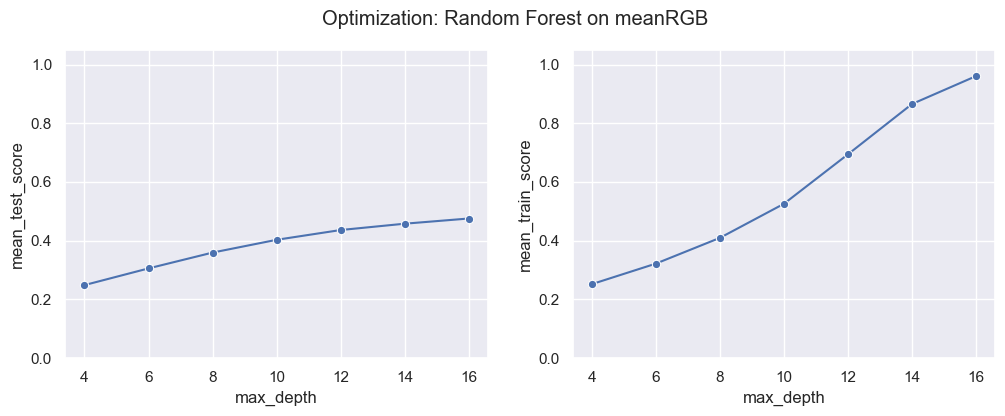

In [104]:
fig, axs = plt.subplots(1,2,figsize = (12,4))
#sns.lineplot(x = 'max_depth', y='mean_test_score', data = grid_rf_optimization, hue = 'criterion', style='max_features', marker = 'o')


sns.lineplot(x = 'max_depth', y='mean_test_score', data = grid_rf_optimization, \
             marker = 'o', ax= axs[0])

# sns.lineplot(x = 'max_depth', y='mean_test_score', data = grid_rf_v0, hue = 'C',\
#              marker = '*', ax= axs[0], ls = ':', palette="crest")


sns.lineplot(x = 'max_depth', y='mean_train_score', data = grid_rf_optimization, \
             marker = 'o', ax= axs[1])

# sns.lineplot(x = 'max_depth', y='mean_train_score', data = grid_rf_v0, hue = 'C',\
#              marker = '*', ax= axs[1], ls = ':', palette="crest")

for ax in axs:
    ax.set_ylim(0,1.05)
#     ax.set_xscale("log")
#     leg = ax.legend()
#     leg_lines = leg.get_lines()
# #     leg_lines[1].set_linestyle(":")
#     leg_lines[2].set_linestyle(":")
#     leg_lines[3].set_linestyle(":")
    
#plt.legend(title='Day of Week')
# plt.legend(labels = ['a', 'F', 'S', 'y'])
fig.suptitle("Optimization: Random Forest on meanRGB")

**Train-Test accuracy**

In [115]:
rf_accuracy_train = rf_clf.score(X_train, y_train)
rf_accuracy_test = rf_clf.score(X_test, y_test)

# rf_accuracy_train = grid_rf.score(X_train, y_train)
# rf_accuracy_test = grid_rf.score(X_test, y_test)

print("Train set accuracy %0.3f" % rf_accuracy_train)
print("Test  set accuracy %0.3f" % rf_accuracy_test)

Train set accuracy 0.661
Test  set accuracy 0.428


**Predictions**

In [116]:
y_pred = rf_clf.predict(X_test)
# y_pred = grid_rf.predict(X_test)

cm = pd.crosstab(y_test, y_pred, rownames=['Reality'], colnames=['Predictions'])
#print(cm.shape)
#display(cm)

(27, 25)


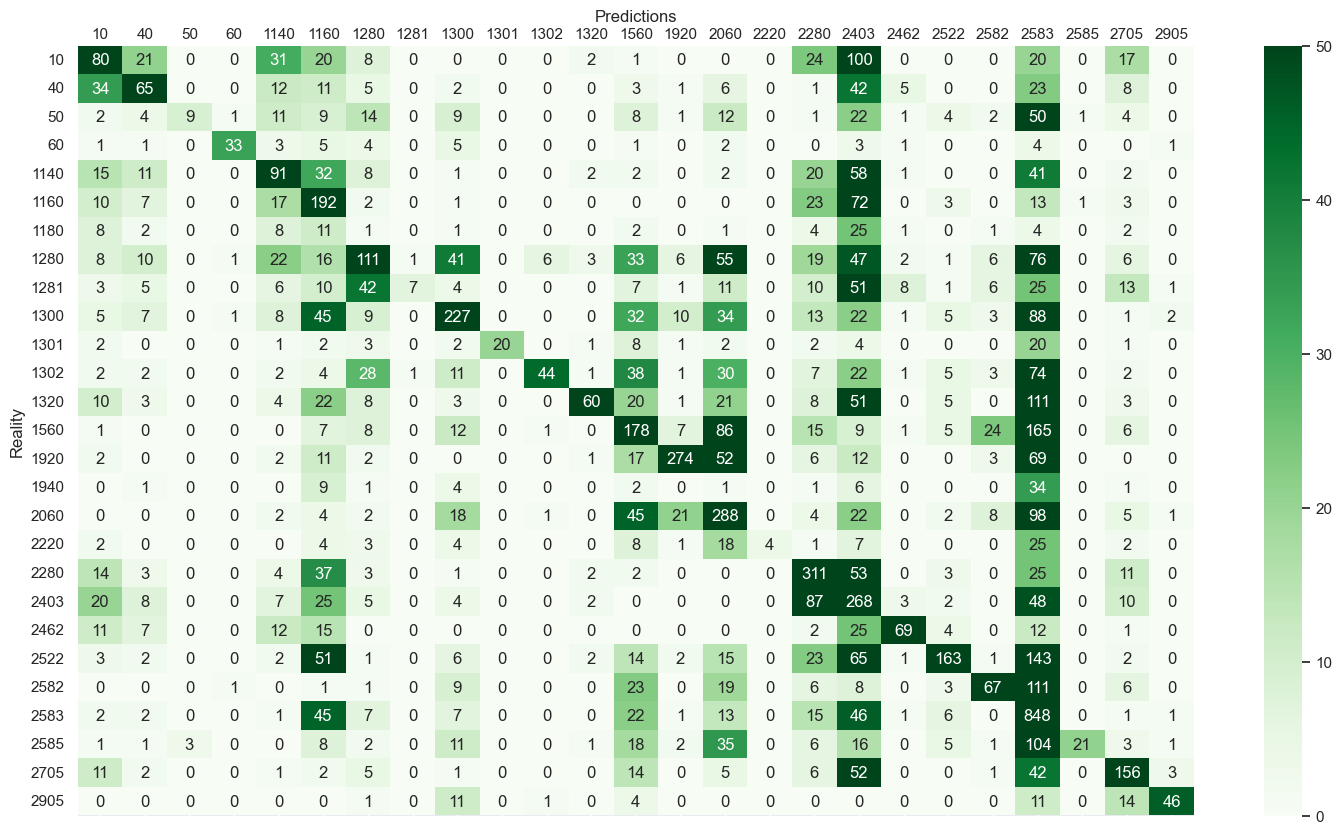

In [117]:
print(cm.shape)

fig, ax = plt.subplots(figsize = (18,10))
sns.heatmap(cm, annot = True, ax=ax, cmap='Greens', fmt ='d', vmin = 0, vmax = 50)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_tick_params(length = 0)
ax.xaxis.set_label_position('top')

**Save confusion matrix**

In [118]:
export = True

if export:
    filename = 'textModel_rf' + model_date_time + '_confusionMatrix.csv'
    
    with open(filename, 'w') as file:
        cm.to_csv(filename, header = True, index = True)
        print(filename)

textModel_rf_20230807_2330_confusionMatrix.csv


**Classification Report: macro & micro**

In [119]:
from sklearn.metrics import classification_report 

cr = classification_report(y_test, y_pred, output_dict = True)
cr.update({"accuracy": {"precision": None, "recall": None, "f1-score": cr["accuracy"], "support": cr['macro avg']['support']}})

micro_rf = pd.DataFrame(cr).transpose().reset_index().rename(columns={'index': 'prdtypecode'}).iloc[:-3,:]
macro_rf = pd.DataFrame(cr).transpose().reset_index().rename(columns={'index': 'metrics'}).iloc[-3:,:]

# display(micro_dt)
# display(macro_dt)

C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [120]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          10       0.32      0.25      0.28       324
          40       0.40      0.30      0.34       218
          50       0.75      0.05      0.10       165
          60       0.89      0.52      0.65        64
        1140       0.37      0.32      0.34       286
        1160       0.32      0.56      0.41       344
        1180       0.00      0.00      0.00        71
        1280       0.39      0.24      0.29       470
        1281       0.78      0.03      0.06       211
        1300       0.57      0.44      0.50       513
        1301       1.00      0.29      0.45        69
        1302       0.83      0.16      0.27       278
        1320       0.78      0.18      0.29       330
        1560       0.35      0.34      0.35       525
        1920       0.83      0.61      0.70       451
        1940       0.00      0.00      0.00        60
        2060       0.41      0.55      0.47       521
        2220       1.00    

C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Top Classified Categories**

In [121]:
micro_rf.sort_values(by = 'f1-score', ascending=False).head(5)

,prdtypecode,precision,recall,f1-score,support
14,1920,0.830303,0.607539,0.701665,451.0
3,60,0.891892,0.515625,0.653465,64.0
26,2905,0.821429,0.522727,0.638889,88.0
18,2280,0.505691,0.663113,0.573801,469.0
20,2462,0.718750,0.436709,0.543307,158.0


**Save Classification Report**

In [122]:
export = True

if export:
    filename = 'textModel_rf' + model_date_time + '_classificationReport.txt'
    
    with open(filename, 'w') as file:
        file.write(classification_report(y_test, y_pred))
        print(filename)

textModel_rf_20230807_2330_classificationReport.txt


C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Save trained model**

In [124]:
export = True

if export:
    filename = 'textModel_rf_trainedModel' + model_date_time + '.txt'
    print(filename)
    
    with open(filename, 'w') as file:
        file.write(json.dumps(rf_clf.get_params()))

textModel_rf_trainedModel_20230807_2330.txt


**Load pre-Trained model**

In [89]:
export = False

if export:
    filename = 'textModel_rf_trainedModel' + learnCurve_date_time + '.txt'
    
    with open(filename, 'r') as file:
        reloadedModel = json.load(file)
        
    reloadedModel

# SVM.SVC model


In [172]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

## estimator
svc_clf = svm.SVC(C = 10, kernel = 'rbf') # kernel = 'poly', gamma = 0.01

## GridSearch
# params = {'gamma' : [1e-11,1e-10,1e-9,1e-8,1e-7,1e-6]}#,
# #          'C' : [1e3,1e4,1e5,1e6] }

# grid_svc = GridSearchCV(estimator = svc_clf, param_grid = params, scoring = 'accuracy', n_jobs = -1, cv = 3,\
#                           return_train_score=True, verbose = 3)

## training (timed)
t0 = time.time()

svc_clf.fit(X_train, y_train)
# grid_svc.fit(X_train, y_train)

t1 = time.time()
print("For %d observations, training time = %0.2f seconds" %(X_train.shape[0], (t1-t0) ) )

model_date_time = date_time()
print(model_date_time)

For 33967 observations, training time = 157.04 seconds
_20230808_0001


**Train-Test accuracy**

In [173]:
t0 = time.time()

svc_accuracy_train = svc_clf.score(X_train, y_train)
svc_accuracy_test = svc_clf.score(X_test, y_test)

# svc_accuracy_train = grid_svc.score(X_train, y_train)
# svc_accuracy_test = grid_svc.score(X_test, y_test)

print("Train set accuracy %0.3f" % svc_accuracy_train)
print("Test  set accuracy %0.3f" % svc_accuracy_test)

t1 = time.time()
print("Training and test set accuracy measured in %0.2f seconds" %((t1-t0) ) )

Train set accuracy 0.473
Test  set accuracy 0.432
Training and test set accuracy measured in 257.20 seconds


**Predictions**

In [174]:
t0 = time.time()

y_pred = svc_clf.predict(X_test)
# y_pred = grid_rf_px.predict(X_test)

t1 = time.time()
print("Predictions done in %0.2f seconds" %((t1-t0) ) )

cm = pd.crosstab(y_test, y_pred, rownames=['Reality'], colnames=['Predictions'])
#print(cm.shape)
#display(cm)

Predictions done in 53.46 seconds


(27, 26)


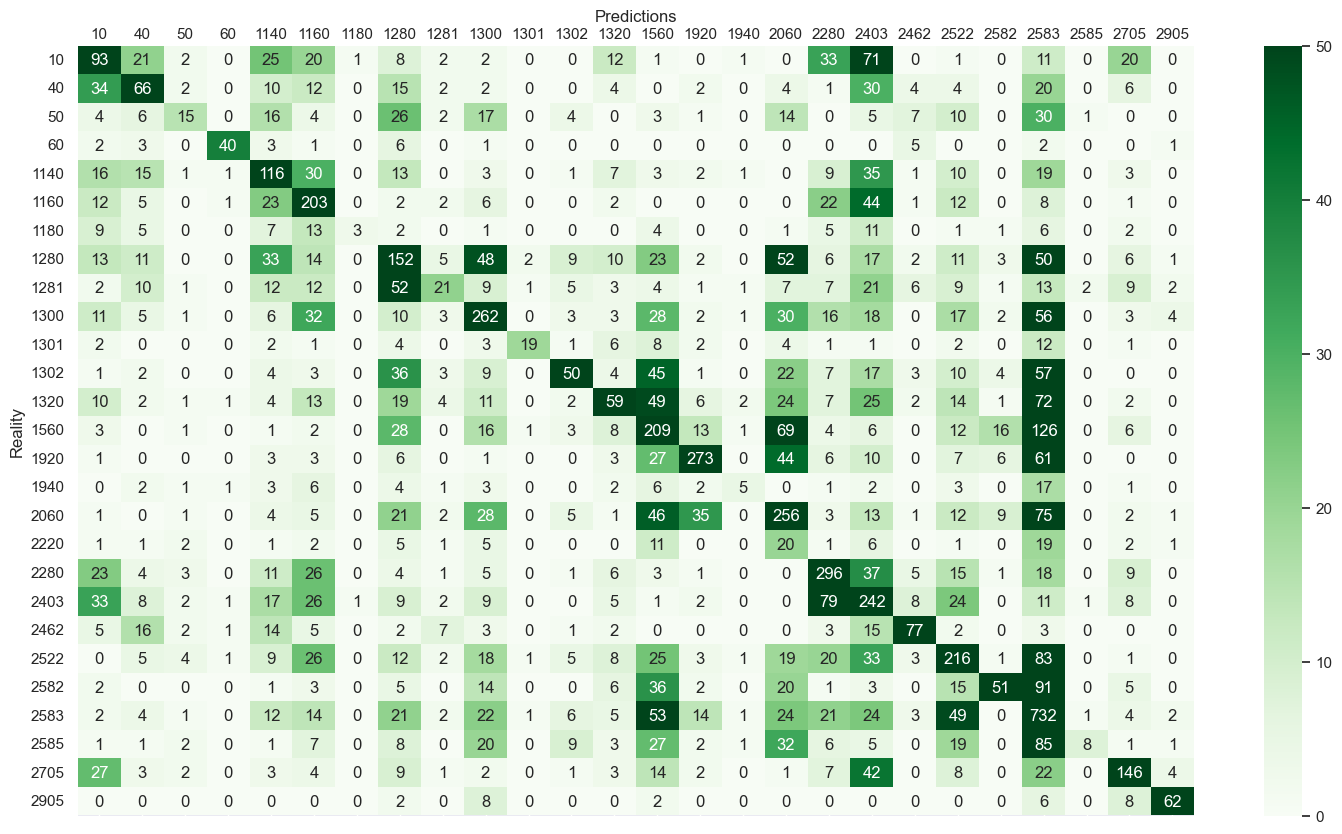

In [175]:
print(cm.shape)

fig, ax = plt.subplots(figsize = (18,10))
sns.heatmap(cm, annot = True, ax=ax, cmap='Greens', fmt ='d', vmin = 0, vmax = 50)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_tick_params(length = 0)
ax.xaxis.set_label_position('top')

**Save confusion matrix**

In [179]:
export = True

if export:
    filename = 'textModel_svc' + model_date_time + '_confusionMatrix.csv'
    
    with open(filename, 'w') as file:
        cm.to_csv(filename, header = True, index = True)
        print(filename)

textModel_svc_20230808_0001_confusionMatrix.csv


**Classification Report: macro & micro**

In [176]:
from sklearn.metrics import classification_report 

cr = classification_report(y_test, y_pred, output_dict = True)
cr.update({"accuracy": {"precision": None, "recall": None, "f1-score": cr["accuracy"], "support": cr['macro avg']['support']}})

micro_rf = pd.DataFrame(cr).transpose().reset_index().rename(columns={'index': 'prdtypecode'}).iloc[:-3,:]
macro_rf = pd.DataFrame(cr).transpose().reset_index().rename(columns={'index': 'metrics'}).iloc[-3:,:]

# display(micro_dt)
# display(macro_dt)

C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [177]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          10       0.30      0.29      0.29       324
          40       0.34      0.30      0.32       218
          50       0.34      0.09      0.14       165
          60       0.85      0.62      0.72        64
        1140       0.34      0.41      0.37       286
        1160       0.42      0.59      0.49       344
        1180       0.60      0.04      0.08        71
        1280       0.32      0.32      0.32       470
        1281       0.33      0.10      0.15       211
        1300       0.50      0.51      0.50       513
        1301       0.76      0.28      0.40        69
        1302       0.47      0.18      0.26       278
        1320       0.36      0.18      0.24       330
        1560       0.33      0.40      0.36       525
        1920       0.74      0.61      0.67       451
        1940       0.33      0.08      0.13        60
        2060       0.40      0.49      0.44       521
        2220       0.00    

C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Top Classified Categories**

In [178]:
micro_rf.sort_values(by = 'f1-score', ascending=False).head(5)

,prdtypecode,precision,recall,f1-score,support
26,2905,0.784810,0.704545,0.742515,88.0
3,60,0.851064,0.625000,0.720721,64.0
14,1920,0.741848,0.605322,0.666667,451.0
18,2280,0.526690,0.631130,0.574200,469.0
20,2462,0.601562,0.487342,0.538462,158.0


**Save Classification Report**

In [180]:
export = True

if export:
    filename = 'textModel_svc' + model_date_time + '_classificationReport.txt'
    
    with open(filename, 'w') as file:
        file.write(classification_report(y_test, y_pred))
        print(filename)

textModel_svc_20230808_0001_classificationReport.txt


C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Save model hyperparameters**

In [181]:
export = True

if export:
    filename = 'textModel_svc_trainedModel' + model_date_time + '.txt'
    print(filename)
    
    with open(filename, 'w') as file:
        file.write(json.dumps(rf_clf.get_params()))

textModel_svc_trainedModel_20230808_0001.txt


**Load model hyperparameters**

In [185]:
export = True

if export:
    filename = 'textModel_svc_trainedModel_20230808_0001.txt'
    
    with open(filename, 'r') as file:
        reloadedModel = json.load(file)
        
    print(reloadedModel)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}


# Simple Neural Network
- [x] Normalize features [0,1] range

- [ ] LAbelEncoder target to go from 0 to 26
- [ ] One hot encode target variable: vector --> matrix

- [ ] NN model
- [ ] NN compiler
- [ ] 

**Label encoder**

In [19]:
from sklearn.preprocessing import LabelEncoder

target_encoder = LabelEncoder()

y_train_encoded = target_encoder.fit_transform(y_train)
y_test_encoded = target_encoder.transform(y_test)

target_encoder.classes_
# target_encoder.inverse_transform(y_test)
# target_encoder.inverse_transform([18])

array([  10,   40,   50,   60, 1140, 1160, 1180, 1280, 1281, 1300, 1301,
       1302, 1320, 1560, 1920, 1940, 2060, 2220, 2280, 2403, 2462, 2522,
       2582, 2583, 2585, 2705, 2905], dtype=int64)

**On-Hot-Encoding of target variables**

In [20]:
from tensorflow.keras.utils import to_categorical

yy_train = to_categorical(y_train_encoded, dtype = 'int') 
yy_test = to_categorical(y_test_encoded, dtype = 'int')   

yy_train.shape

(67932, 27)

In [21]:
i = 20
print("Exmaple %d: Class '%d' is encoded as vector:"%(i, y_train.iloc[i]), y_train_encoded[i], yy_train[i,:])

Exmaple 20: Class '1300' is encoded as vector: 9 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


**Define model : NN layers**

In [22]:
X_train.shape[1]

120

In [88]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

## data dimensions
Nb_features = X_train.shape[1]
Nb_classes = yy_train.shape[1]


## instantiate layers

inputs = Input(shape = Nb_features, name = "Input")

dense1 = Dense(units = 128, activation = "relu", \
               kernel_initializer ='normal', name = "Dense_1")

dense2 = Dense(units = Nb_classes, activation = "softmax", \
               kernel_initializer ='normal', name = "Dense_2")


## link layers & model

x = dense1(inputs)
outputs = dense2(x)

NN_clf = Model(inputs = inputs, outputs = outputs)

In [89]:
## to visualize a schema of the model

NN_clf.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 120)]             0         
                                                                 
 Dense_1 (Dense)             (None, 128)               15488     
                                                                 
 Dense_2 (Dense)             (None, 27)                3483      
                                                                 
Total params: 18,971
Trainable params: 18,971
Non-trainable params: 0
_________________________________________________________________


**Define training process**

In [90]:
NN_clf.compile(loss = 'categorical_crossentropy',  
              optimizer = 'adam',                 
              metrics = ['accuracy'])             


**Train Model**

In [92]:
t0 = time.time()

training_history = NN_clf.fit(X_train.toarray(), yy_train,          
                             epochs = 1000,               
                             batch_size = 500,          
                             validation_split = 0.2)

t1 = time.time()
print("For %d observations, training time = %0.2f seconds" %(X_train.shape[0], (t1-t0) ) )

model_date_time = date_time()
print(model_date_time)

Epoch 1/1000
109/109 [==============================] - 1s 6ms/step - loss: 3.0870 - accuracy: 0.1211 - val_loss: 2.9556 - val_accuracy: 0.1397
Epoch 2/1000
109/109 [==============================] - 0s 4ms/step - loss: 2.8630 - accuracy: 0.1703 - val_loss: 2.7572 - val_accuracy: 0.1935
Epoch 3/1000
109/109 [==============================] - 0s 4ms/step - loss: 2.6972 - accuracy: 0.2061 - val_loss: 2.6340 - val_accuracy: 0.2268
Epoch 4/1000
109/109 [==============================] - 0s 3ms/step - loss: 2.6031 - accuracy: 0.2306 - val_loss: 2.5596 - val_accuracy: 0.2435
Epoch 5/1000
109/109 [==============================] - 0s 4ms/step - loss: 2.5337 - accuracy: 0.2552 - val_loss: 2.4984 - val_accuracy: 0.2693
Epoch 6/1000
109/109 [==============================] - 0s 4ms/step - loss: 2.4767 - accuracy: 0.2861 - val_loss: 2.4477 - val_accuracy: 0.2969
Epoch 7/1000
109/109 [==============================] - 0s 4ms/step - loss: 2.4288 - accuracy: 0.3112 - val_loss: 2.4061 - val_accuracy:

109/109 [==============================] - 0s 3ms/step - loss: 1.9499 - accuracy: 0.4381 - val_loss: 1.9808 - val_accuracy: 0.4284
Epoch 58/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.9452 - accuracy: 0.4397 - val_loss: 1.9766 - val_accuracy: 0.4264
Epoch 59/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.9416 - accuracy: 0.4388 - val_loss: 1.9730 - val_accuracy: 0.4291
Epoch 60/1000
109/109 [==============================] - 0s 3ms/step - loss: 1.9373 - accuracy: 0.4414 - val_loss: 1.9701 - val_accuracy: 0.4331
Epoch 61/1000
109/109 [==============================] - 0s 3ms/step - loss: 1.9338 - accuracy: 0.4420 - val_loss: 1.9686 - val_accuracy: 0.4329
Epoch 62/1000
109/109 [==============================] - 0s 3ms/step - loss: 1.9304 - accuracy: 0.4438 - val_loss: 1.9658 - val_accuracy: 0.4319
Epoch 63/1000
109/109 [==============================] - 0s 3ms/step - loss: 1.9267 - accuracy: 0.4442 - val_loss: 1.9615 - val_accuracy: 0.4333

109/109 [==============================] - 0s 4ms/step - loss: 1.8037 - accuracy: 0.4770 - val_loss: 1.8772 - val_accuracy: 0.4557
Epoch 114/1000
109/109 [==============================] - 0s 3ms/step - loss: 1.8021 - accuracy: 0.4773 - val_loss: 1.8762 - val_accuracy: 0.4604
Epoch 115/1000
109/109 [==============================] - 0s 3ms/step - loss: 1.7998 - accuracy: 0.4774 - val_loss: 1.8758 - val_accuracy: 0.4576
Epoch 116/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.7986 - accuracy: 0.4778 - val_loss: 1.8749 - val_accuracy: 0.4618
Epoch 117/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.7978 - accuracy: 0.4781 - val_loss: 1.8725 - val_accuracy: 0.4600
Epoch 118/1000
109/109 [==============================] - 0s 3ms/step - loss: 1.7948 - accuracy: 0.4783 - val_loss: 1.8726 - val_accuracy: 0.4601
Epoch 119/1000
109/109 [==============================] - 0s 3ms/step - loss: 1.7945 - accuracy: 0.4793 - val_loss: 1.8701 - val_accuracy: 

109/109 [==============================] - 0s 4ms/step - loss: 1.7326 - accuracy: 0.4939 - val_loss: 1.8391 - val_accuracy: 0.4681
Epoch 170/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.7311 - accuracy: 0.4956 - val_loss: 1.8400 - val_accuracy: 0.4672
Epoch 171/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.7304 - accuracy: 0.4960 - val_loss: 1.8407 - val_accuracy: 0.4677
Epoch 172/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.7296 - accuracy: 0.4958 - val_loss: 1.8399 - val_accuracy: 0.4676
Epoch 173/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.7287 - accuracy: 0.4956 - val_loss: 1.8402 - val_accuracy: 0.4679
Epoch 174/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.7275 - accuracy: 0.4967 - val_loss: 1.8393 - val_accuracy: 0.4702
Epoch 175/1000
109/109 [==============================] - 0s 3ms/step - loss: 1.7270 - accuracy: 0.4962 - val_loss: 1.8355 - val_accuracy: 

109/109 [==============================] - 0s 4ms/step - loss: 1.6867 - accuracy: 0.5080 - val_loss: 1.8241 - val_accuracy: 0.4729
Epoch 226/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.6860 - accuracy: 0.5068 - val_loss: 1.8227 - val_accuracy: 0.4761
Epoch 227/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.6853 - accuracy: 0.5075 - val_loss: 1.8255 - val_accuracy: 0.4724
Epoch 228/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.6848 - accuracy: 0.5066 - val_loss: 1.8240 - val_accuracy: 0.4748
Epoch 229/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.6847 - accuracy: 0.5074 - val_loss: 1.8231 - val_accuracy: 0.4736
Epoch 230/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.6828 - accuracy: 0.5078 - val_loss: 1.8217 - val_accuracy: 0.4740
Epoch 231/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.6825 - accuracy: 0.5083 - val_loss: 1.8242 - val_accuracy: 

109/109 [==============================] - 0s 4ms/step - loss: 1.6537 - accuracy: 0.5162 - val_loss: 1.8183 - val_accuracy: 0.4779
Epoch 282/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.6530 - accuracy: 0.5157 - val_loss: 1.8163 - val_accuracy: 0.4772
Epoch 283/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.6534 - accuracy: 0.5152 - val_loss: 1.8203 - val_accuracy: 0.4766
Epoch 284/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.6536 - accuracy: 0.5155 - val_loss: 1.8183 - val_accuracy: 0.4777
Epoch 285/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.6519 - accuracy: 0.5151 - val_loss: 1.8178 - val_accuracy: 0.4799
Epoch 286/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.6516 - accuracy: 0.5162 - val_loss: 1.8203 - val_accuracy: 0.4794
Epoch 287/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.6516 - accuracy: 0.5167 - val_loss: 1.8162 - val_accuracy: 

109/109 [==============================] - 0s 4ms/step - loss: 1.6309 - accuracy: 0.5204 - val_loss: 1.8170 - val_accuracy: 0.4783
Epoch 338/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.6305 - accuracy: 0.5216 - val_loss: 1.8149 - val_accuracy: 0.4813
Epoch 339/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.6289 - accuracy: 0.5222 - val_loss: 1.8154 - val_accuracy: 0.4785
Epoch 340/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.6290 - accuracy: 0.5223 - val_loss: 1.8175 - val_accuracy: 0.4800
Epoch 341/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.6281 - accuracy: 0.5222 - val_loss: 1.8169 - val_accuracy: 0.4785
Epoch 342/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.6280 - accuracy: 0.5230 - val_loss: 1.8144 - val_accuracy: 0.4812
Epoch 343/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.6275 - accuracy: 0.5218 - val_loss: 1.8157 - val_accuracy: 

109/109 [==============================] - 0s 4ms/step - loss: 1.6112 - accuracy: 0.5268 - val_loss: 1.8182 - val_accuracy: 0.4799
Epoch 394/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.6113 - accuracy: 0.5270 - val_loss: 1.8160 - val_accuracy: 0.4795
Epoch 395/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.6114 - accuracy: 0.5273 - val_loss: 1.8149 - val_accuracy: 0.4816
Epoch 396/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.6098 - accuracy: 0.5271 - val_loss: 1.8180 - val_accuracy: 0.4797
Epoch 397/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.6106 - accuracy: 0.5278 - val_loss: 1.8154 - val_accuracy: 0.4799
Epoch 398/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.6099 - accuracy: 0.5276 - val_loss: 1.8167 - val_accuracy: 0.4806
Epoch 399/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.6104 - accuracy: 0.5268 - val_loss: 1.8166 - val_accuracy: 

109/109 [==============================] - 0s 4ms/step - loss: 1.5963 - accuracy: 0.5310 - val_loss: 1.8179 - val_accuracy: 0.4830
Epoch 450/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5968 - accuracy: 0.5306 - val_loss: 1.8206 - val_accuracy: 0.4810
Epoch 451/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5967 - accuracy: 0.5315 - val_loss: 1.8242 - val_accuracy: 0.4803
Epoch 452/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5967 - accuracy: 0.5304 - val_loss: 1.8171 - val_accuracy: 0.4833
Epoch 453/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5972 - accuracy: 0.5313 - val_loss: 1.8173 - val_accuracy: 0.4812
Epoch 454/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5961 - accuracy: 0.5303 - val_loss: 1.8170 - val_accuracy: 0.4812
Epoch 455/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5965 - accuracy: 0.5303 - val_loss: 1.8207 - val_accuracy: 

109/109 [==============================] - 0s 4ms/step - loss: 1.5852 - accuracy: 0.5341 - val_loss: 1.8212 - val_accuracy: 0.4820
Epoch 506/1000
109/109 [==============================] - 0s 3ms/step - loss: 1.5845 - accuracy: 0.5349 - val_loss: 1.8234 - val_accuracy: 0.4834
Epoch 507/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5842 - accuracy: 0.5341 - val_loss: 1.8204 - val_accuracy: 0.4836
Epoch 508/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5849 - accuracy: 0.5348 - val_loss: 1.8202 - val_accuracy: 0.4834
Epoch 509/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5847 - accuracy: 0.5345 - val_loss: 1.8228 - val_accuracy: 0.4827
Epoch 510/1000
109/109 [==============================] - 0s 3ms/step - loss: 1.5838 - accuracy: 0.5341 - val_loss: 1.8222 - val_accuracy: 0.4826
Epoch 511/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5840 - accuracy: 0.5355 - val_loss: 1.8198 - val_accuracy: 

109/109 [==============================] - 0s 3ms/step - loss: 1.5747 - accuracy: 0.5357 - val_loss: 1.8233 - val_accuracy: 0.4873
Epoch 562/1000
109/109 [==============================] - 0s 3ms/step - loss: 1.5748 - accuracy: 0.5359 - val_loss: 1.8220 - val_accuracy: 0.4830
Epoch 563/1000
109/109 [==============================] - 0s 3ms/step - loss: 1.5744 - accuracy: 0.5375 - val_loss: 1.8232 - val_accuracy: 0.4822
Epoch 564/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5746 - accuracy: 0.5365 - val_loss: 1.8261 - val_accuracy: 0.4840
Epoch 565/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5740 - accuracy: 0.5371 - val_loss: 1.8223 - val_accuracy: 0.4830
Epoch 566/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5738 - accuracy: 0.5363 - val_loss: 1.8234 - val_accuracy: 0.4810
Epoch 567/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5733 - accuracy: 0.5367 - val_loss: 1.8221 - val_accuracy: 

109/109 [==============================] - 0s 4ms/step - loss: 1.5645 - accuracy: 0.5390 - val_loss: 1.8244 - val_accuracy: 0.4842
Epoch 618/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5644 - accuracy: 0.5393 - val_loss: 1.8252 - val_accuracy: 0.4858
Epoch 619/1000
109/109 [==============================] - 0s 3ms/step - loss: 1.5664 - accuracy: 0.5378 - val_loss: 1.8235 - val_accuracy: 0.4839
Epoch 620/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5640 - accuracy: 0.5393 - val_loss: 1.8267 - val_accuracy: 0.4845
Epoch 621/1000
109/109 [==============================] - 0s 3ms/step - loss: 1.5652 - accuracy: 0.5390 - val_loss: 1.8228 - val_accuracy: 0.4848
Epoch 622/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5639 - accuracy: 0.5391 - val_loss: 1.8239 - val_accuracy: 0.4852
Epoch 623/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5640 - accuracy: 0.5393 - val_loss: 1.8254 - val_accuracy: 

109/109 [==============================] - 0s 4ms/step - loss: 1.5574 - accuracy: 0.5406 - val_loss: 1.8289 - val_accuracy: 0.4857
Epoch 674/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5571 - accuracy: 0.5410 - val_loss: 1.8286 - val_accuracy: 0.4833
Epoch 675/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5560 - accuracy: 0.5413 - val_loss: 1.8265 - val_accuracy: 0.4844
Epoch 676/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5569 - accuracy: 0.5414 - val_loss: 1.8291 - val_accuracy: 0.4859
Epoch 677/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5565 - accuracy: 0.5413 - val_loss: 1.8305 - val_accuracy: 0.4833
Epoch 678/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5564 - accuracy: 0.5408 - val_loss: 1.8266 - val_accuracy: 0.4835
Epoch 679/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5555 - accuracy: 0.5417 - val_loss: 1.8303 - val_accuracy: 

109/109 [==============================] - 0s 4ms/step - loss: 1.5496 - accuracy: 0.5419 - val_loss: 1.8273 - val_accuracy: 0.4863
Epoch 730/1000
109/109 [==============================] - 0s 3ms/step - loss: 1.5487 - accuracy: 0.5433 - val_loss: 1.8297 - val_accuracy: 0.4869
Epoch 731/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5492 - accuracy: 0.5435 - val_loss: 1.8283 - val_accuracy: 0.4860
Epoch 732/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5496 - accuracy: 0.5428 - val_loss: 1.8314 - val_accuracy: 0.4850
Epoch 733/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5488 - accuracy: 0.5432 - val_loss: 1.8273 - val_accuracy: 0.4880
Epoch 734/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5490 - accuracy: 0.5431 - val_loss: 1.8281 - val_accuracy: 0.4852
Epoch 735/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5480 - accuracy: 0.5432 - val_loss: 1.8291 - val_accuracy: 

109/109 [==============================] - 0s 4ms/step - loss: 1.5426 - accuracy: 0.5447 - val_loss: 1.8324 - val_accuracy: 0.4855
Epoch 786/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5427 - accuracy: 0.5451 - val_loss: 1.8309 - val_accuracy: 0.4874
Epoch 787/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5433 - accuracy: 0.5434 - val_loss: 1.8304 - val_accuracy: 0.4869
Epoch 788/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5425 - accuracy: 0.5449 - val_loss: 1.8320 - val_accuracy: 0.4859
Epoch 789/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5419 - accuracy: 0.5444 - val_loss: 1.8301 - val_accuracy: 0.4838
Epoch 790/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5421 - accuracy: 0.5437 - val_loss: 1.8314 - val_accuracy: 0.4867
Epoch 791/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5415 - accuracy: 0.5452 - val_loss: 1.8306 - val_accuracy: 

109/109 [==============================] - 0s 4ms/step - loss: 1.5356 - accuracy: 0.5469 - val_loss: 1.8337 - val_accuracy: 0.4866
Epoch 842/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5368 - accuracy: 0.5461 - val_loss: 1.8327 - val_accuracy: 0.4855
Epoch 843/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5358 - accuracy: 0.5461 - val_loss: 1.8316 - val_accuracy: 0.4888
Epoch 844/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5355 - accuracy: 0.5465 - val_loss: 1.8321 - val_accuracy: 0.4873
Epoch 845/1000
109/109 [==============================] - 0s 3ms/step - loss: 1.5357 - accuracy: 0.5470 - val_loss: 1.8332 - val_accuracy: 0.4860
Epoch 846/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5367 - accuracy: 0.5456 - val_loss: 1.8316 - val_accuracy: 0.4883
Epoch 847/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5364 - accuracy: 0.5453 - val_loss: 1.8367 - val_accuracy: 

109/109 [==============================] - 0s 4ms/step - loss: 1.5313 - accuracy: 0.5486 - val_loss: 1.8330 - val_accuracy: 0.4881
Epoch 898/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5304 - accuracy: 0.5484 - val_loss: 1.8338 - val_accuracy: 0.4883
Epoch 899/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5303 - accuracy: 0.5474 - val_loss: 1.8344 - val_accuracy: 0.4859
Epoch 900/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5306 - accuracy: 0.5479 - val_loss: 1.8339 - val_accuracy: 0.4870
Epoch 901/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5304 - accuracy: 0.5474 - val_loss: 1.8345 - val_accuracy: 0.4877
Epoch 902/1000
109/109 [==============================] - 0s 3ms/step - loss: 1.5310 - accuracy: 0.5472 - val_loss: 1.8324 - val_accuracy: 0.4877
Epoch 903/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5306 - accuracy: 0.5481 - val_loss: 1.8334 - val_accuracy: 

109/109 [==============================] - 0s 4ms/step - loss: 1.5259 - accuracy: 0.5491 - val_loss: 1.8344 - val_accuracy: 0.4878
Epoch 954/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5249 - accuracy: 0.5491 - val_loss: 1.8379 - val_accuracy: 0.4887
Epoch 955/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5253 - accuracy: 0.5504 - val_loss: 1.8330 - val_accuracy: 0.4878
Epoch 956/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5256 - accuracy: 0.5508 - val_loss: 1.8367 - val_accuracy: 0.4895
Epoch 957/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5255 - accuracy: 0.5490 - val_loss: 1.8345 - val_accuracy: 0.4888
Epoch 958/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5252 - accuracy: 0.5494 - val_loss: 1.8350 - val_accuracy: 0.4885
Epoch 959/1000
109/109 [==============================] - 0s 4ms/step - loss: 1.5259 - accuracy: 0.5496 - val_loss: 1.8372 - val_accuracy: 

**Score Evolution during training**

In [93]:
x_epochs = np.arange(1,1001,1)

train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

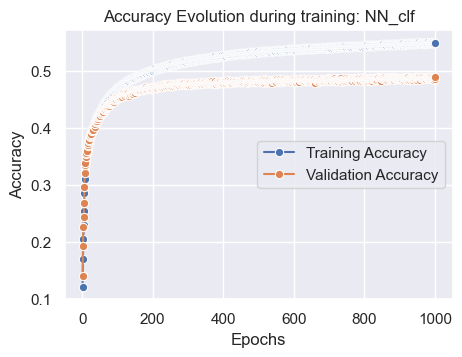

In [94]:
plt.figure(figsize=(5,3.5))

sns.lineplot(x = x_epochs, y = train_acc, marker = 'o', label = 'Training Accuracy')
sns.lineplot(x = x_epochs, y = val_acc, marker = 'o', label = 'Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Evolution during training: NN_clf')
plt.legend(loc='right')

**Train-Test accuracy**

In [95]:
loss_train, NN_accuracy_train = NN_clf.evaluate(X_train.toarray(), yy_train)
loss_test, NN_accuracy_test = NN_clf.evaluate(X_test.toarray(), yy_test)

# svc_accuracy_train = grid_svc.score(X_train, y_train)
# svc_accuracy_test = grid_svc.score(X_test, y_test)

print("Train set accuracy = %0.3f and loss function = %0.2f" %(NN_accuracy_train, loss_train) )
print("Test  set accuracy = %0.3f and loss function = %0.2f" %(NN_accuracy_test, loss_test))

531/531 [==============================] - 1s 2ms/step - loss: 1.8453 - accuracy: 0.4872
Train set accuracy = 0.540 and loss function = 1.58
Test  set accuracy = 0.487 and loss function = 1.85


**Predictions**

In [31]:
y_pred_vectors = NN_clf.predict(X_test.toarray())

## reverse One-hot-encoding
y_pred_class = y_pred_vectors.argmax(axis = 1)
yy_test_class = yy_test.argmax(axis = 1)

## reverse label encoder
y_pred = target_encoder.inverse_transform(y_pred_class)
yy_test_prdCode = target_encoder.inverse_transform(yy_test_class)   # should be equal to y_test



531/531 [==============================] - 1s 1ms/step


In [32]:
print(yy_test_prdCode)
print(y_test.values)

[1140 1320 2582 ... 2280 2522 1920]
[1140 1320 2582 ... 2280 2522 1920]


**Confussion Matrix**

In [33]:
cm = pd.crosstab(y_test, y_pred, rownames=['Reality'], colnames=['Predictions'])
#print(cm.shape)
#display(cm)

(27, 27)


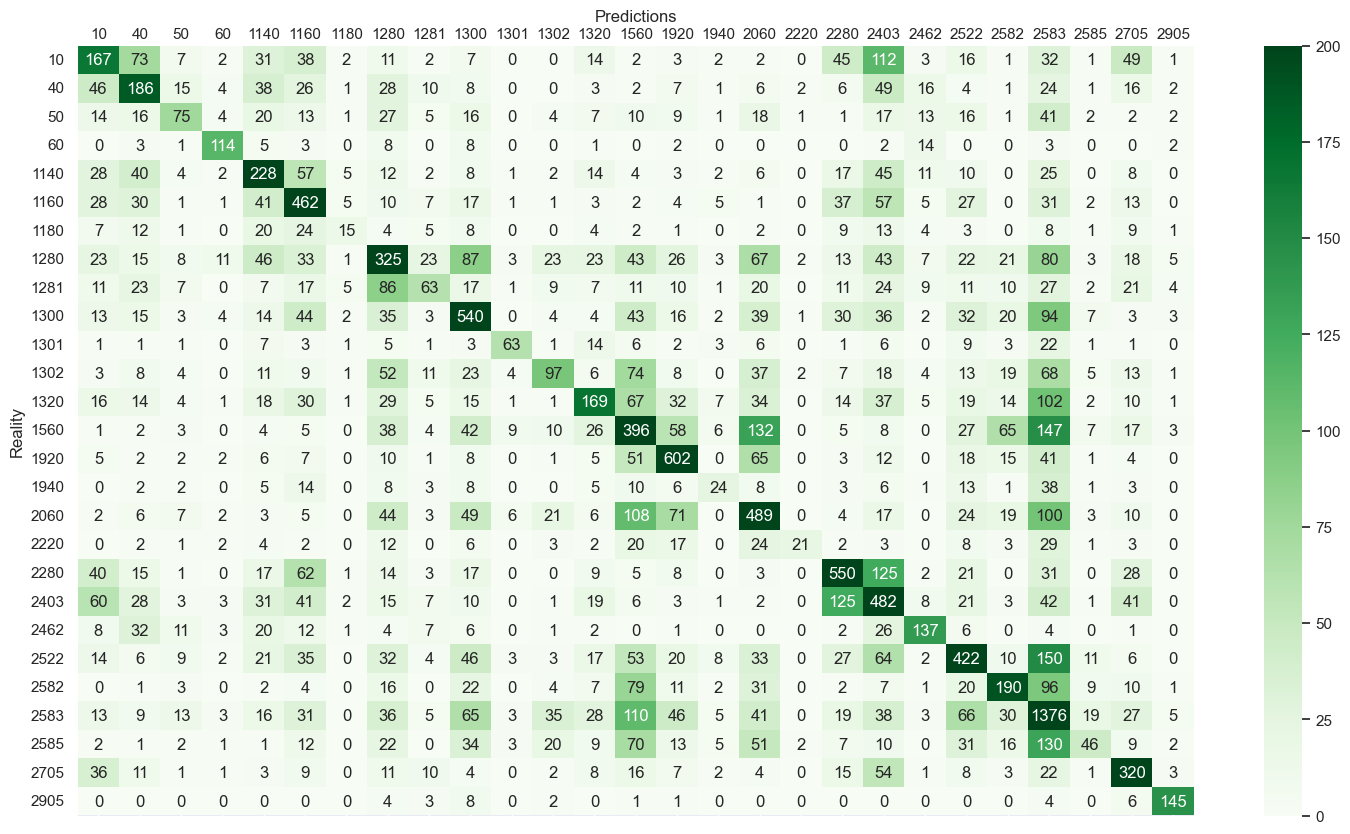

In [37]:
print(cm.shape)

fig, ax = plt.subplots(figsize = (18,10))
sns.heatmap(cm, annot = True, ax=ax, cmap='Greens', fmt ='d', vmin = 0, vmax = 200)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_tick_params(length = 0)
ax.xaxis.set_label_position('top')

**Save confusion matrix**

In [60]:
export = False

if export:
    filename = 'textModel_svc' + model_date_time + '_confusionMatrix.csv'
    
    with open(filename, 'w') as file:
        cm.to_csv(filename, header = True, index = True)
        print(filename)

**Classification Report: macro & micro**

In [38]:
from sklearn.metrics import classification_report 

cr = classification_report(y_test, y_pred, output_dict = True)
cr.update({"accuracy": {"precision": None, "recall": None, "f1-score": cr["accuracy"], "support": cr['macro avg']['support']}})

micro_rf = pd.DataFrame(cr).transpose().reset_index().rename(columns={'index': 'prdtypecode'}).iloc[:-3,:]
macro_rf = pd.DataFrame(cr).transpose().reset_index().rename(columns={'index': 'metrics'}).iloc[-3:,:]

# display(micro_dt)
# display(macro_dt)

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          10       0.31      0.27      0.29       623
          40       0.34      0.37      0.35       502
          50       0.40      0.22      0.29       336
          60       0.70      0.69      0.70       166
        1140       0.37      0.43      0.40       534
        1160       0.46      0.58      0.52       791
        1180       0.34      0.10      0.15       153
        1280       0.36      0.33      0.35       974
        1281       0.34      0.15      0.21       414
        1300       0.50      0.54      0.52      1009
        1301       0.64      0.39      0.49       161
        1302       0.40      0.19      0.26       498
        1320       0.41      0.26      0.32       648
        1560       0.33      0.39      0.36      1015
        1920       0.61      0.70      0.65       861
        1940       0.30      0.15      0.20       161
        2060       0.44      0.49      0.46       999
        2220       0.68    

**Top Classified Categories**

In [279]:
micro_rf.sort_values(by = 'f1-score', ascending=False).head(5)

,prdtypecode,precision,recall,f1-score,support
23,2583,0.106848,1.000000,0.193067,181.0
0,10,1.000000,0.012658,0.025000,79.0
14,1920,0.000000,0.000000,0.000000,82.0
25,2705,0.000000,0.000000,0.000000,63.0
24,2585,0.000000,0.000000,0.000000,54.0


**Save Classification Report**

In [280]:
export = False

if export:
    filename = 'textModel_svc' + model_date_time + '_classificationReport.txt'
    
    with open(filename, 'w') as file:
        file.write(classification_report(y_test, y_pred))
        print(filename)

**Save trained model**

In [284]:
export = False

if export:
    filename = 'textModel_NN_trainedModel' + model_date_time + '.txt'
    
    with open(filename, 'w') as file:
        file.write(json.dumps(NN_clf.get_params()))
        print(filename)


**Load pre-Trained model**

In [283]:
reload = False

if reload:
    filename = 'textModel_NN_trainedModel' + learnCurve_date_time + '.txt'
    
    with open(filename, 'r') as file:
        reloadedModel = json.load(file)
        
    reloadedModel

## Parameters tunning

**My grid search**

In [195]:
def my_grid_search(params, X_train, y_train, X_test, y_test, Nepoch = 200, batch_sz = 200):
    
    '''
    params : d1_unit, d1_act
    '''
    
    ## build model
    Nb_features = X_train.shape[1]
    Nb_classes = y_train.shape[1]
    
    param_trained = []
    train_histories = []
    
    train_acc_hist = []
    val_acc_hist = []
    
    acc_train = []
    acc_test = []

    losses_train = []
    losses_test = []

    
    for d1_unit in params['d1_units']:
        for d1_act in params['d1_act']:
            
            param_trained.append( (d1_unit, d1_act) ) 
            NN_clf = initialize_model(Nb_features, Nb_classes, d1_units = d1_unit, d1_act = d1_act)
    
            ## train model
            training_history = NN_clf.fit(X_train.toarray(), y_train,          
                             epochs = Nepoch,               
                             batch_size = batch_sz,          
                             validation_split = 0.2)
            
            train_histories.append(training_history)
            
            train_acc_hist.append(list(training_history.history['accuracy']))
            val_acc_hist.append(list(training_history.history['val_accuracy']))
            
            ## train test accuracy
            loss_train, accuracy_train = NN_clf.evaluate(X_train.toarray(), y_train)
            loss_test, accuracy_test = NN_clf.evaluate(X_test.toarray(), y_test)
            
            losses_train.append(loss_train)
            losses_test.append(loss_test)

            acc_train.append(accuracy_train)
            acc_test.append(accuracy_test)
            
#             loss_accuracy_train.append(NN_clf.evaluate(X_train.toarray(), y_train))
#             loss_accuracy_test.append(NN_clf.evaluate(X_test.toarray(), y_test))    
            
            
    results = {'param_trained' : param_trained,
               'train_histories' : train_histories,
               'train_acc_hist' : train_acc_hist,
               'val_acc_hist' : val_acc_hist,
               'accuracy_train' : acc_train,
               'accuracy_test' : acc_test,
               'loss_train' : losses_train,
               'loss_test' : losses_test}
            

    return results


def initialize_model(Nb_features, Nb_classes, d1_units = 64, d1_act = 'relu'):

    ## instantiate layers
    inputs = Input(shape = Nb_features, name = "Input")
    dense1 = Dense(units = d1_units, activation = d1_act, \
                   kernel_initializer ='normal', name = "Dense_1")
    dense2 = Dense(units = Nb_classes, activation = "softmax", \
                   kernel_initializer ='normal', name = "Dense_2")


    ## link layers & model
    x = dense1(inputs)
    outputs = dense2(x)
    NN_clf = Model(inputs = inputs, outputs = outputs)
    
    
    ## compile
    NN_clf.compile(loss = 'categorical_crossentropy',  
              optimizer = 'adam',                 
              metrics = ['accuracy'])             

    
    return NN_clf

In [197]:
t0 = time.time()

parameters = {'d1_units' : [16,32,45,64,75,100,128],
              'd1_act' : ['relu']}

#X_train =X_train, y_train = yy_train, X_test = X_test, y_test=yy_test
#X_train, yy_train, X_test, yy_test
grid_results = my_grid_search(params = parameters, 
                              X_train = X_train, y_train = yy_train, 
                              X_test = X_test, y_test = yy_test,
                              Nepoch = 200, batch_sz = 200)

t1 = time.time()
print("For %d observations, training time = %0.2f seconds" %(X_train.shape[0], (t1-t0) ) )

Epoch 1/200
272/272 [==============================] - 1s 3ms/step - loss: 3.1177 - accuracy: 0.1184 - val_loss: 3.0216 - val_accuracy: 0.1326
Epoch 2/200
272/272 [==============================] - 1s 3ms/step - loss: 2.9598 - accuracy: 0.1423 - val_loss: 2.8828 - val_accuracy: 0.1643
Epoch 3/200
272/272 [==============================] - 1s 2ms/step - loss: 2.8271 - accuracy: 0.1836 - val_loss: 2.7637 - val_accuracy: 0.2021
Epoch 4/200
272/272 [==============================] - 1s 2ms/step - loss: 2.7356 - accuracy: 0.1990 - val_loss: 2.6962 - val_accuracy: 0.2101
Epoch 5/200
272/272 [==============================] - 1s 2ms/step - loss: 2.6824 - accuracy: 0.2048 - val_loss: 2.6535 - val_accuracy: 0.2094
Epoch 6/200
272/272 [==============================] - 1s 2ms/step - loss: 2.6461 - accuracy: 0.2118 - val_loss: 2.6240 - val_accuracy: 0.2151
Epoch 7/200
272/272 [==============================] - 1s 3ms/step - loss: 2.6169 - accuracy: 0.2200 - val_loss: 2.5940 - val_accuracy: 0.2264

Epoch 58/200
272/272 [==============================] - 1s 3ms/step - loss: 2.2047 - accuracy: 0.3702 - val_loss: 2.2184 - val_accuracy: 0.3672
Epoch 59/200
272/272 [==============================] - 1s 3ms/step - loss: 2.2028 - accuracy: 0.3712 - val_loss: 2.2162 - val_accuracy: 0.3681
Epoch 60/200
272/272 [==============================] - 1s 2ms/step - loss: 2.2010 - accuracy: 0.3716 - val_loss: 2.2148 - val_accuracy: 0.3690
Epoch 61/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1992 - accuracy: 0.3717 - val_loss: 2.2128 - val_accuracy: 0.3685
Epoch 62/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1978 - accuracy: 0.3724 - val_loss: 2.2139 - val_accuracy: 0.3681
Epoch 63/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1964 - accuracy: 0.3718 - val_loss: 2.2114 - val_accuracy: 0.3687
Epoch 64/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1949 - accuracy: 0.3740 - val_loss: 2.2090 - val_accuracy:

Epoch 115/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1459 - accuracy: 0.3821 - val_loss: 2.1632 - val_accuracy: 0.3798
Epoch 116/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1449 - accuracy: 0.3836 - val_loss: 2.1640 - val_accuracy: 0.3795
Epoch 117/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1444 - accuracy: 0.3829 - val_loss: 2.1622 - val_accuracy: 0.3795
Epoch 118/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1439 - accuracy: 0.3831 - val_loss: 2.1620 - val_accuracy: 0.3804
Epoch 119/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1429 - accuracy: 0.3834 - val_loss: 2.1619 - val_accuracy: 0.3805
Epoch 120/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1423 - accuracy: 0.3836 - val_loss: 2.1615 - val_accuracy: 0.3809
Epoch 121/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1419 - accuracy: 0.3842 - val_loss: 2.1602 - val_ac

272/272 [==============================] - 1s 3ms/step - loss: 2.1170 - accuracy: 0.3883 - val_loss: 2.1378 - val_accuracy: 0.3840
Epoch 172/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1168 - accuracy: 0.3885 - val_loss: 2.1360 - val_accuracy: 0.3871
Epoch 173/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1163 - accuracy: 0.3882 - val_loss: 2.1377 - val_accuracy: 0.3888
Epoch 174/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1160 - accuracy: 0.3873 - val_loss: 2.1365 - val_accuracy: 0.3841
Epoch 175/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1152 - accuracy: 0.3890 - val_loss: 2.1359 - val_accuracy: 0.3849
Epoch 176/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1153 - accuracy: 0.3883 - val_loss: 2.1359 - val_accuracy: 0.3855
Epoch 177/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1148 - accuracy: 0.3897 - val_loss: 2.1349 - val_accuracy: 0.3854

272/272 [==============================] - 1s 3ms/step - loss: 2.2099 - accuracy: 0.3707 - val_loss: 2.2202 - val_accuracy: 0.3711
Epoch 27/200
272/272 [==============================] - 1s 3ms/step - loss: 2.2034 - accuracy: 0.3725 - val_loss: 2.2111 - val_accuracy: 0.3757
Epoch 28/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1960 - accuracy: 0.3745 - val_loss: 2.2063 - val_accuracy: 0.3703
Epoch 29/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1897 - accuracy: 0.3751 - val_loss: 2.2000 - val_accuracy: 0.3737
Epoch 30/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1840 - accuracy: 0.3776 - val_loss: 2.1929 - val_accuracy: 0.3763
Epoch 31/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1774 - accuracy: 0.3792 - val_loss: 2.1855 - val_accuracy: 0.3749
Epoch 32/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1717 - accuracy: 0.3812 - val_loss: 2.1827 - val_accuracy: 0.3775
Epoch

Epoch 83/200
272/272 [==============================] - 1s 3ms/step - loss: 2.0146 - accuracy: 0.4172 - val_loss: 2.0415 - val_accuracy: 0.4125
Epoch 84/200
272/272 [==============================] - 1s 3ms/step - loss: 2.0129 - accuracy: 0.4163 - val_loss: 2.0420 - val_accuracy: 0.4140
Epoch 85/200
272/272 [==============================] - 1s 3ms/step - loss: 2.0111 - accuracy: 0.4174 - val_loss: 2.0425 - val_accuracy: 0.4140
Epoch 86/200
272/272 [==============================] - 1s 3ms/step - loss: 2.0097 - accuracy: 0.4171 - val_loss: 2.0392 - val_accuracy: 0.4153
Epoch 87/200
272/272 [==============================] - 1s 3ms/step - loss: 2.0081 - accuracy: 0.4183 - val_loss: 2.0371 - val_accuracy: 0.4150
Epoch 88/200
272/272 [==============================] - 1s 3ms/step - loss: 2.0068 - accuracy: 0.4187 - val_loss: 2.0358 - val_accuracy: 0.4156
Epoch 89/200
272/272 [==============================] - 1s 3ms/step - loss: 2.0052 - accuracy: 0.4187 - val_loss: 2.0351 - val_accuracy:

272/272 [==============================] - 1s 3ms/step - loss: 1.9575 - accuracy: 0.4323 - val_loss: 2.0003 - val_accuracy: 0.4253
Epoch 140/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9573 - accuracy: 0.4312 - val_loss: 2.0007 - val_accuracy: 0.4247
Epoch 141/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9568 - accuracy: 0.4317 - val_loss: 2.0012 - val_accuracy: 0.4258
Epoch 142/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9562 - accuracy: 0.4311 - val_loss: 1.9993 - val_accuracy: 0.4264
Epoch 143/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9557 - accuracy: 0.4322 - val_loss: 1.9984 - val_accuracy: 0.4256
Epoch 144/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9546 - accuracy: 0.4323 - val_loss: 1.9996 - val_accuracy: 0.4252
Epoch 145/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9539 - accuracy: 0.4324 - val_loss: 1.9978 - val_accuracy: 0.4261

272/272 [==============================] - 1s 3ms/step - loss: 1.9325 - accuracy: 0.4364 - val_loss: 1.9841 - val_accuracy: 0.4305
Epoch 196/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9318 - accuracy: 0.4368 - val_loss: 1.9811 - val_accuracy: 0.4306
Epoch 197/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9318 - accuracy: 0.4374 - val_loss: 1.9857 - val_accuracy: 0.4264
Epoch 198/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9311 - accuracy: 0.4378 - val_loss: 1.9824 - val_accuracy: 0.4295
Epoch 199/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9306 - accuracy: 0.4386 - val_loss: 1.9830 - val_accuracy: 0.4291
Epoch 200/200
531/531 [==============================] - 1s 2ms/step - loss: 1.9897 - accuracy: 0.4297
Epoch 1/200
272/272 [==============================] - 2s 4ms/step - loss: 3.0496 - accuracy: 0.1316 - val_loss: 2.9165 - val_accuracy: 0.1445
Epoch 2/200
272/272 [======================

Epoch 51/200
272/272 [==============================] - 1s 3ms/step - loss: 2.0186 - accuracy: 0.4181 - val_loss: 2.0416 - val_accuracy: 0.4122
Epoch 52/200
272/272 [==============================] - 1s 3ms/step - loss: 2.0155 - accuracy: 0.4193 - val_loss: 2.0408 - val_accuracy: 0.4137
Epoch 53/200
272/272 [==============================] - 1s 3ms/step - loss: 2.0125 - accuracy: 0.4192 - val_loss: 2.0350 - val_accuracy: 0.4166
Epoch 54/200
272/272 [==============================] - 1s 3ms/step - loss: 2.0090 - accuracy: 0.4206 - val_loss: 2.0340 - val_accuracy: 0.4168
Epoch 55/200
272/272 [==============================] - 1s 3ms/step - loss: 2.0062 - accuracy: 0.4208 - val_loss: 2.0310 - val_accuracy: 0.4164
Epoch 56/200
272/272 [==============================] - 1s 3ms/step - loss: 2.0029 - accuracy: 0.4221 - val_loss: 2.0290 - val_accuracy: 0.4159
Epoch 57/200
272/272 [==============================] - 1s 3ms/step - loss: 2.0001 - accuracy: 0.4237 - val_loss: 2.0259 - val_accuracy:

Epoch 108/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9147 - accuracy: 0.4455 - val_loss: 1.9591 - val_accuracy: 0.4363
Epoch 109/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9138 - accuracy: 0.4464 - val_loss: 1.9602 - val_accuracy: 0.4373
Epoch 110/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9123 - accuracy: 0.4457 - val_loss: 1.9588 - val_accuracy: 0.4364
Epoch 111/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9119 - accuracy: 0.4462 - val_loss: 1.9576 - val_accuracy: 0.4374
Epoch 112/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9106 - accuracy: 0.4470 - val_loss: 1.9572 - val_accuracy: 0.4357
Epoch 113/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9092 - accuracy: 0.4468 - val_loss: 1.9584 - val_accuracy: 0.4355
Epoch 114/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9089 - accuracy: 0.4470 - val_loss: 1.9558 - val_ac

272/272 [==============================] - 1s 3ms/step - loss: 1.8738 - accuracy: 0.4535 - val_loss: 1.9322 - val_accuracy: 0.4466
Epoch 165/200
272/272 [==============================] - 1s 4ms/step - loss: 1.8728 - accuracy: 0.4555 - val_loss: 1.9314 - val_accuracy: 0.4455
Epoch 166/200
272/272 [==============================] - 1s 4ms/step - loss: 1.8721 - accuracy: 0.4553 - val_loss: 1.9312 - val_accuracy: 0.4455
Epoch 167/200
272/272 [==============================] - 1s 4ms/step - loss: 1.8720 - accuracy: 0.4545 - val_loss: 1.9341 - val_accuracy: 0.4449
Epoch 168/200
272/272 [==============================] - 1s 4ms/step - loss: 1.8712 - accuracy: 0.4568 - val_loss: 1.9317 - val_accuracy: 0.4438
Epoch 169/200
272/272 [==============================] - 1s 3ms/step - loss: 1.8705 - accuracy: 0.4560 - val_loss: 1.9308 - val_accuracy: 0.4445
Epoch 170/200
272/272 [==============================] - 1s 4ms/step - loss: 1.8712 - accuracy: 0.4553 - val_loss: 1.9329 - val_accuracy: 0.4465

272/272 [==============================] - 1s 3ms/step - loss: 2.1795 - accuracy: 0.3797 - val_loss: 2.1868 - val_accuracy: 0.3852
Epoch 20/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1699 - accuracy: 0.3810 - val_loss: 2.1719 - val_accuracy: 0.3832
Epoch 21/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1610 - accuracy: 0.3846 - val_loss: 2.1651 - val_accuracy: 0.3860
Epoch 22/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1523 - accuracy: 0.3865 - val_loss: 2.1557 - val_accuracy: 0.3857
Epoch 23/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1427 - accuracy: 0.3882 - val_loss: 2.1479 - val_accuracy: 0.3885
Epoch 24/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1340 - accuracy: 0.3901 - val_loss: 2.1414 - val_accuracy: 0.3905
Epoch 25/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1272 - accuracy: 0.3923 - val_loss: 2.1349 - val_accuracy: 0.3922
Epoch

Epoch 76/200
272/272 [==============================] - 1s 4ms/step - loss: 1.9232 - accuracy: 0.4432 - val_loss: 1.9656 - val_accuracy: 0.4366
Epoch 77/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9213 - accuracy: 0.4442 - val_loss: 1.9678 - val_accuracy: 0.4364
Epoch 78/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9188 - accuracy: 0.4451 - val_loss: 1.9615 - val_accuracy: 0.4339
Epoch 79/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9171 - accuracy: 0.4454 - val_loss: 1.9603 - val_accuracy: 0.4393
Epoch 80/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9160 - accuracy: 0.4454 - val_loss: 1.9591 - val_accuracy: 0.4386
Epoch 81/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9132 - accuracy: 0.4456 - val_loss: 1.9576 - val_accuracy: 0.4417
Epoch 82/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9113 - accuracy: 0.4472 - val_loss: 1.9551 - val_accuracy:

272/272 [==============================] - 1s 3ms/step - loss: 1.8462 - accuracy: 0.4631 - val_loss: 1.9123 - val_accuracy: 0.4526
Epoch 133/200
272/272 [==============================] - 1s 3ms/step - loss: 1.8449 - accuracy: 0.4637 - val_loss: 1.9100 - val_accuracy: 0.4523
Epoch 134/200
272/272 [==============================] - 1s 4ms/step - loss: 1.8438 - accuracy: 0.4638 - val_loss: 1.9079 - val_accuracy: 0.4559
Epoch 135/200
272/272 [==============================] - 1s 3ms/step - loss: 1.8437 - accuracy: 0.4637 - val_loss: 1.9129 - val_accuracy: 0.4521
Epoch 136/200
272/272 [==============================] - 1s 4ms/step - loss: 1.8426 - accuracy: 0.4638 - val_loss: 1.9056 - val_accuracy: 0.4571
Epoch 137/200
272/272 [==============================] - 1s 3ms/step - loss: 1.8414 - accuracy: 0.4646 - val_loss: 1.9080 - val_accuracy: 0.4551
Epoch 138/200
272/272 [==============================] - 1s 4ms/step - loss: 1.8422 - accuracy: 0.4638 - val_loss: 1.9075 - val_accuracy: 0.4546

272/272 [==============================] - 1s 4ms/step - loss: 1.8091 - accuracy: 0.4726 - val_loss: 1.8908 - val_accuracy: 0.4551
Epoch 189/200
272/272 [==============================] - 1s 3ms/step - loss: 1.8082 - accuracy: 0.4718 - val_loss: 1.8852 - val_accuracy: 0.4583
Epoch 190/200
272/272 [==============================] - 1s 3ms/step - loss: 1.8070 - accuracy: 0.4730 - val_loss: 1.8867 - val_accuracy: 0.4585
Epoch 191/200
272/272 [==============================] - 1s 3ms/step - loss: 1.8072 - accuracy: 0.4715 - val_loss: 1.8913 - val_accuracy: 0.4590
Epoch 192/200
272/272 [==============================] - 1s 3ms/step - loss: 1.8060 - accuracy: 0.4729 - val_loss: 1.8870 - val_accuracy: 0.4577
Epoch 193/200
272/272 [==============================] - 1s 3ms/step - loss: 1.8057 - accuracy: 0.4725 - val_loss: 1.8923 - val_accuracy: 0.4571
Epoch 194/200
272/272 [==============================] - 1s 3ms/step - loss: 1.8050 - accuracy: 0.4724 - val_loss: 1.8852 - val_accuracy: 0.4592

Epoch 44/200
272/272 [==============================] - 1s 4ms/step - loss: 1.9932 - accuracy: 0.4250 - val_loss: 2.0190 - val_accuracy: 0.4188
Epoch 45/200
272/272 [==============================] - 1s 4ms/step - loss: 1.9888 - accuracy: 0.4264 - val_loss: 2.0182 - val_accuracy: 0.4194
Epoch 46/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9850 - accuracy: 0.4280 - val_loss: 2.0143 - val_accuracy: 0.4192
Epoch 47/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9801 - accuracy: 0.4292 - val_loss: 2.0115 - val_accuracy: 0.4227
Epoch 48/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9765 - accuracy: 0.4299 - val_loss: 2.0056 - val_accuracy: 0.4222
Epoch 49/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9724 - accuracy: 0.4309 - val_loss: 2.0027 - val_accuracy: 0.4226
Epoch 50/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9681 - accuracy: 0.4318 - val_loss: 2.0009 - val_accuracy:

Epoch 101/200
272/272 [==============================] - 1s 3ms/step - loss: 1.8496 - accuracy: 0.4618 - val_loss: 1.9153 - val_accuracy: 0.4459
Epoch 102/200
272/272 [==============================] - 1s 3ms/step - loss: 1.8477 - accuracy: 0.4616 - val_loss: 1.9188 - val_accuracy: 0.4486
Epoch 103/200
272/272 [==============================] - 1s 3ms/step - loss: 1.8472 - accuracy: 0.4620 - val_loss: 1.9126 - val_accuracy: 0.4501
Epoch 104/200
272/272 [==============================] - 1s 3ms/step - loss: 1.8455 - accuracy: 0.4628 - val_loss: 1.9174 - val_accuracy: 0.4513
Epoch 105/200
272/272 [==============================] - 1s 3ms/step - loss: 1.8441 - accuracy: 0.4641 - val_loss: 1.9135 - val_accuracy: 0.4495
Epoch 106/200
272/272 [==============================] - 1s 3ms/step - loss: 1.8424 - accuracy: 0.4645 - val_loss: 1.9155 - val_accuracy: 0.4485
Epoch 107/200
272/272 [==============================] - 1s 4ms/step - loss: 1.8415 - accuracy: 0.4646 - val_loss: 1.9104 - val_ac

272/272 [==============================] - 1s 3ms/step - loss: 1.7905 - accuracy: 0.4785 - val_loss: 1.8893 - val_accuracy: 0.4624
Epoch 158/200
272/272 [==============================] - 1s 4ms/step - loss: 1.7900 - accuracy: 0.4778 - val_loss: 1.8913 - val_accuracy: 0.4603
Epoch 159/200
272/272 [==============================] - 1s 3ms/step - loss: 1.7890 - accuracy: 0.4782 - val_loss: 1.8866 - val_accuracy: 0.4614
Epoch 160/200
272/272 [==============================] - 1s 3ms/step - loss: 1.7874 - accuracy: 0.4774 - val_loss: 1.8858 - val_accuracy: 0.4621
Epoch 161/200
272/272 [==============================] - 1s 4ms/step - loss: 1.7870 - accuracy: 0.4784 - val_loss: 1.8844 - val_accuracy: 0.4623
Epoch 162/200
272/272 [==============================] - 1s 3ms/step - loss: 1.7862 - accuracy: 0.4785 - val_loss: 1.8877 - val_accuracy: 0.4608
Epoch 163/200
272/272 [==============================] - 1s 3ms/step - loss: 1.7852 - accuracy: 0.4793 - val_loss: 1.8875 - val_accuracy: 0.4619

272/272 [==============================] - 1s 3ms/step - loss: 2.2174 - accuracy: 0.3713 - val_loss: 2.2151 - val_accuracy: 0.3730
Epoch 13/200
272/272 [==============================] - 1s 3ms/step - loss: 2.2028 - accuracy: 0.3740 - val_loss: 2.2021 - val_accuracy: 0.3748
Epoch 14/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1872 - accuracy: 0.3789 - val_loss: 2.1851 - val_accuracy: 0.3797
Epoch 15/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1725 - accuracy: 0.3821 - val_loss: 2.1791 - val_accuracy: 0.3825
Epoch 16/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1599 - accuracy: 0.3849 - val_loss: 2.1617 - val_accuracy: 0.3796
Epoch 17/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1469 - accuracy: 0.3888 - val_loss: 2.1538 - val_accuracy: 0.3851
Epoch 18/200
272/272 [==============================] - 1s 3ms/step - loss: 2.1349 - accuracy: 0.3916 - val_loss: 2.1403 - val_accuracy: 0.3902
Epoch

Epoch 69/200
272/272 [==============================] - 1s 3ms/step - loss: 1.8518 - accuracy: 0.4639 - val_loss: 1.9052 - val_accuracy: 0.4497
Epoch 70/200
272/272 [==============================] - 1s 3ms/step - loss: 1.8507 - accuracy: 0.4638 - val_loss: 1.9020 - val_accuracy: 0.4523
Epoch 71/200
272/272 [==============================] - 1s 3ms/step - loss: 1.8475 - accuracy: 0.4634 - val_loss: 1.9040 - val_accuracy: 0.4537
Epoch 72/200
272/272 [==============================] - 1s 3ms/step - loss: 1.8455 - accuracy: 0.4646 - val_loss: 1.9014 - val_accuracy: 0.4493
Epoch 73/200
272/272 [==============================] - 1s 3ms/step - loss: 1.8432 - accuracy: 0.4653 - val_loss: 1.8964 - val_accuracy: 0.4543
Epoch 74/200
272/272 [==============================] - 1s 3ms/step - loss: 1.8403 - accuracy: 0.4647 - val_loss: 1.9008 - val_accuracy: 0.4520
Epoch 75/200
272/272 [==============================] - 1s 3ms/step - loss: 1.8397 - accuracy: 0.4672 - val_loss: 1.8991 - val_accuracy:

Epoch 126/200
272/272 [==============================] - 1s 3ms/step - loss: 1.7625 - accuracy: 0.4860 - val_loss: 1.8616 - val_accuracy: 0.4649
Epoch 127/200
272/272 [==============================] - 1s 3ms/step - loss: 1.7620 - accuracy: 0.4868 - val_loss: 1.8587 - val_accuracy: 0.4652
Epoch 128/200
272/272 [==============================] - 1s 4ms/step - loss: 1.7612 - accuracy: 0.4861 - val_loss: 1.8624 - val_accuracy: 0.4620
Epoch 129/200
272/272 [==============================] - 1s 3ms/step - loss: 1.7587 - accuracy: 0.4868 - val_loss: 1.8607 - val_accuracy: 0.4624
Epoch 130/200
272/272 [==============================] - 1s 3ms/step - loss: 1.7587 - accuracy: 0.4869 - val_loss: 1.8575 - val_accuracy: 0.4653
Epoch 131/200
272/272 [==============================] - 1s 3ms/step - loss: 1.7575 - accuracy: 0.4872 - val_loss: 1.8562 - val_accuracy: 0.4650
Epoch 132/200
272/272 [==============================] - 1s 3ms/step - loss: 1.7559 - accuracy: 0.4864 - val_loss: 1.8555 - val_ac

272/272 [==============================] - 1s 3ms/step - loss: 1.7153 - accuracy: 0.4974 - val_loss: 1.8490 - val_accuracy: 0.4722
Epoch 183/200
272/272 [==============================] - 1s 3ms/step - loss: 1.7154 - accuracy: 0.4979 - val_loss: 1.8425 - val_accuracy: 0.4729
Epoch 184/200
272/272 [==============================] - 1s 4ms/step - loss: 1.7152 - accuracy: 0.4979 - val_loss: 1.8437 - val_accuracy: 0.4746
Epoch 185/200
272/272 [==============================] - 1s 3ms/step - loss: 1.7140 - accuracy: 0.4979 - val_loss: 1.8496 - val_accuracy: 0.4739
Epoch 186/200
272/272 [==============================] - 1s 3ms/step - loss: 1.7135 - accuracy: 0.4988 - val_loss: 1.8464 - val_accuracy: 0.4712
Epoch 187/200
272/272 [==============================] - 1s 4ms/step - loss: 1.7128 - accuracy: 0.4978 - val_loss: 1.8454 - val_accuracy: 0.4719
Epoch 188/200
272/272 [==============================] - 1s 3ms/step - loss: 1.7128 - accuracy: 0.4985 - val_loss: 1.8474 - val_accuracy: 0.4717

272/272 [==============================] - 1s 3ms/step - loss: 1.9310 - accuracy: 0.4411 - val_loss: 1.9607 - val_accuracy: 0.4362
Epoch 38/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9246 - accuracy: 0.4430 - val_loss: 1.9560 - val_accuracy: 0.4353
Epoch 39/200
272/272 [==============================] - 1s 4ms/step - loss: 1.9192 - accuracy: 0.4446 - val_loss: 1.9502 - val_accuracy: 0.4401
Epoch 40/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9130 - accuracy: 0.4468 - val_loss: 1.9482 - val_accuracy: 0.4373
Epoch 41/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9079 - accuracy: 0.4466 - val_loss: 1.9410 - val_accuracy: 0.4411
Epoch 42/200
272/272 [==============================] - 1s 3ms/step - loss: 1.9032 - accuracy: 0.4482 - val_loss: 1.9447 - val_accuracy: 0.4420
Epoch 43/200
272/272 [==============================] - 1s 3ms/step - loss: 1.8979 - accuracy: 0.4504 - val_loss: 1.9330 - val_accuracy: 0.4465
Epoch

Epoch 94/200
272/272 [==============================] - 1s 3ms/step - loss: 1.7516 - accuracy: 0.4880 - val_loss: 1.8455 - val_accuracy: 0.4698
Epoch 95/200
272/272 [==============================] - 1s 3ms/step - loss: 1.7499 - accuracy: 0.4890 - val_loss: 1.8427 - val_accuracy: 0.4707
Epoch 96/200
272/272 [==============================] - 1s 3ms/step - loss: 1.7481 - accuracy: 0.4890 - val_loss: 1.8432 - val_accuracy: 0.4704
Epoch 97/200
272/272 [==============================] - 1s 3ms/step - loss: 1.7469 - accuracy: 0.4889 - val_loss: 1.8395 - val_accuracy: 0.4699
Epoch 98/200
272/272 [==============================] - 1s 3ms/step - loss: 1.7449 - accuracy: 0.4903 - val_loss: 1.8383 - val_accuracy: 0.4704
Epoch 99/200
272/272 [==============================] - 1s 3ms/step - loss: 1.7427 - accuracy: 0.4901 - val_loss: 1.8415 - val_accuracy: 0.4707
Epoch 100/200
272/272 [==============================] - 1s 3ms/step - loss: 1.7412 - accuracy: 0.4917 - val_loss: 1.8370 - val_accuracy

272/272 [==============================] - 1s 3ms/step - loss: 1.6815 - accuracy: 0.5068 - val_loss: 1.8179 - val_accuracy: 0.4795
Epoch 151/200
272/272 [==============================] - 1s 3ms/step - loss: 1.6811 - accuracy: 0.5045 - val_loss: 1.8151 - val_accuracy: 0.4780
Epoch 152/200
272/272 [==============================] - 1s 3ms/step - loss: 1.6804 - accuracy: 0.5056 - val_loss: 1.8191 - val_accuracy: 0.4788
Epoch 153/200
272/272 [==============================] - 1s 3ms/step - loss: 1.6799 - accuracy: 0.5077 - val_loss: 1.8166 - val_accuracy: 0.4802
Epoch 154/200
272/272 [==============================] - 1s 3ms/step - loss: 1.6783 - accuracy: 0.5061 - val_loss: 1.8205 - val_accuracy: 0.4819
Epoch 155/200
272/272 [==============================] - 1s 3ms/step - loss: 1.6777 - accuracy: 0.5064 - val_loss: 1.8206 - val_accuracy: 0.4786
Epoch 156/200
272/272 [==============================] - 1s 3ms/step - loss: 1.6763 - accuracy: 0.5081 - val_loss: 1.8140 - val_accuracy: 0.4805

In [198]:
d1_units = [ item[0] for item in grid_results['param_trained']]
d1_act = [ item[1] for item in grid_results['param_trained']]
accuracy_train = grid_results['accuracy_train']
accuracy_test = grid_results['accuracy_test']

Text(0, 0.5, 'Accuracy')

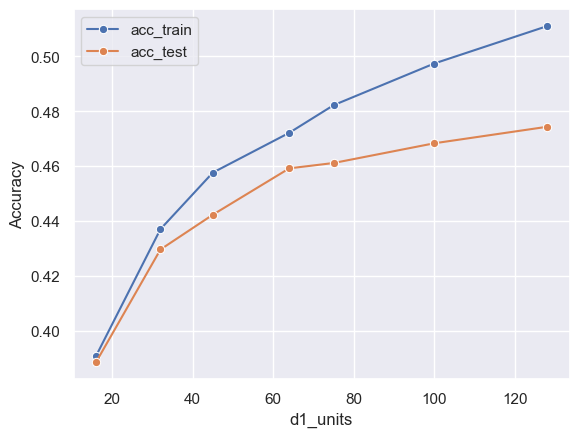

In [219]:
sns.lineplot(x = d1_units, y = accuracy_train, marker = 'o', label='acc_train')
sns.lineplot(x = d1_units, y = accuracy_test, marker = 'o', label='acc_test')

plt.xlabel('d1_units')
plt.ylabel('Accuracy')

**learning curve**

In [200]:
grid_results['train_histories']

In [205]:
Nepoch = 200
x_epochs = np.arange(1,Nepoch+1,1)
training_history = grid_results['train_histories']

In [206]:
sns.color_palette()[0]


(0.2980392156862745, 0.4470588235294118, 0.6901960784313725)

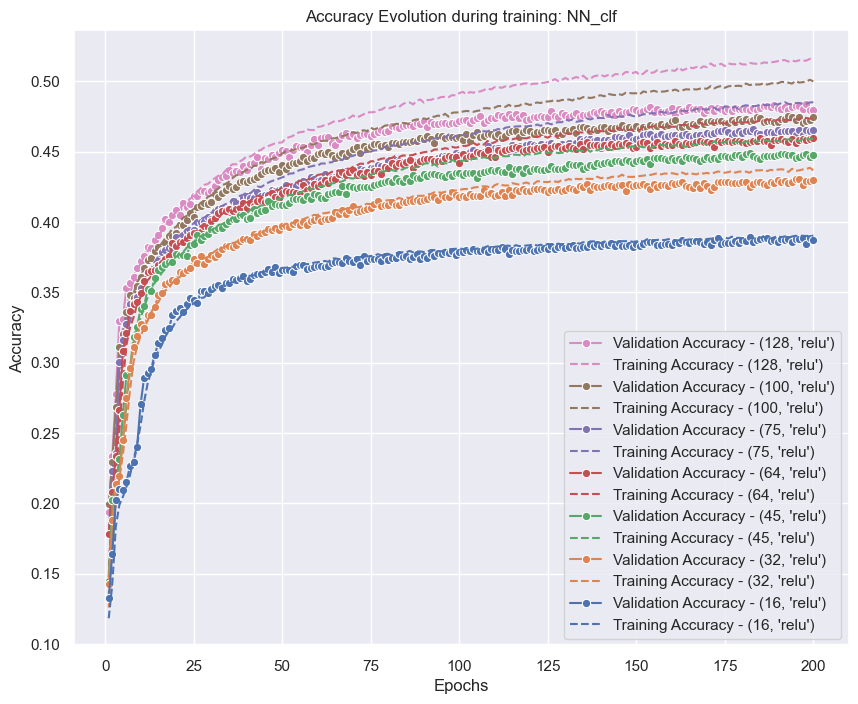

In [228]:
plt.figure(figsize=(10,8))

for i in range(len(training_history)-1,-1,-1):
    
    train_acc_hist = list(training_history[i].history['accuracy'])
    val_acc_hist = list(training_history[i].history['val_accuracy'])
    hist_params = str(grid_results['param_trained'][i])
    
    color =  sns.color_palette()[i]

    sns.lineplot(x = x_epochs, y = val_acc_hist, color = color, marker = 'o', label = 'Validation Accuracy - ' + hist_params)
    sns.lineplot(x = x_epochs, y = train_acc_hist, color = color, ls = '--', label = 'Training Accuracy - ' + hist_params)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Evolution during training: NN_clf')
plt.legend()#

In [227]:
list(grid_results['train_histories'][0].history['accuracy'])
# len(x_epochs)

[0.11839175969362259,
 0.14225779473781586,
 0.18360474705696106,
 0.1989879459142685,
 0.20478424429893494,
 0.21177661418914795,
 0.22002023458480835,
 0.23107922077178955,
 0.2416597604751587,
 0.25577330589294434,
 0.27238935232162476,
 0.28541722893714905,
 0.2939368784427643,
 0.3029901683330536,
 0.3079584240913391,
 0.3126874566078186,
 0.3187413811683655,
 0.32277119159698486,
 0.3251081109046936,
 0.32950592041015625,
 0.3321188688278198,
 0.33576226234436035,
 0.33795198798179626,
 0.3403624892234802,
 0.3422577977180481,
 0.3435274660587311,
 0.34601157903671265,
 0.3465268313884735,
 0.3500230014324188,
 0.35007819533348083,
 0.35167908668518066,
 0.3532247543334961,
 0.3547888398170471,
 0.35488083958625793,
 0.35642653703689575,
 0.35714417695999146,
 0.3588370680809021,
 0.3600147068500519,
 0.3594994843006134,
 0.36133959889411926,
 0.36196520924568176,
 0.3622044324874878,
 0.3630508780479431,
 0.3643757402896881,
 0.3649093806743622,
 0.3651301860809326,
 0.365774214

**save grid resulst**

In [233]:
export = True

grid_model_date_time = date_time()

grid_results_to_save = grid_results.copy()
grid_results_to_save.pop('train_histories')
grid_results_to_save['train_acc_hist'] = list(grid_results['train_histories'][0].history['accuracy'])
grid_results_to_save['val_acc_hist'] = list(grid_results['train_histories'][0].history['val_accuracy'])

if export:
    filename = './Trained_models_and_metrics/' + grid_model_date_time + '_NN_grid_results' +  '.txt'
    print(filename)
    
    with open(filename, 'w') as file:
#         file.write(json.dumps(grid_results_to_save))
        json.dump(grid_results_to_save, file)

./Trained_models_and_metrics/20230812_1241_NN_grid_results.txt


In [ ]:
json.load(./Trained_models_and_metrics/_20230811_2137_NN_grid_results.txt)

In [234]:
file = './Trained_models_and_metrics/20230812_1241_NN_grid_results.txt'
with open(file, 'r') as f:
    reloaded_dict = json.load(f)

In [235]:
reloaded_dict.keys()

dict_keys(['param_trained', 'accuracy_train', 'accuracy_test', 'loss_train', 'loss_test', 'train_acc_hist', 'val_acc_hist'])

# Exporting preprocessed text

In [92]:
write = False
if write:
    filename = 'df_text_preprocessed' + '.csv'
    df.to_csv(filename, header=True, index=False)

In [ ]:
write_pickle = False

t0 = time.time()
if write_pickle:
    filename = 'df_text_preprocessed' + '.pkl'
    df_vectorized_images.to_pickle(filename) #, header=True, index=False

print("Total time = %0.2f seconds" %(time.time()-t0) )    
write_pickle = False

### Most Common words per category 
[ ] how to include this information ? in the dataframe or a model ?

### Feature engineering: Statistical indicators per category
These are the mean, min, max, etc of text_token_len per category.

[ ] How to include them in the dataframe ???

### Save trained model ready to use

In [ ]:
save = False
reload = False

#saved_model = 'Model_svm_optimmized' + model_date_time + '.joblib'
saved_model = 'Model_svm_optimmized' + '_20230803_0742' + '.joblib'

from joblib import dump, load

if save:
    dump(svc_clf, saved_model) #

if reload:
#     my_model=load(saved_model)
    svc_clf=load(saved_model)
    print("reloaded model: ", saved_model)

# Dump non used functions

**CountVectorize -> TFIDF_transform**

In [191]:
# def token_to_text(token_list):
#     '''
#     Concatenate all token of an item to for a sentence (lemmatized already)
#     '''
#     text = '' 
#     for token in token_list:
#         text = text + token + ' '
#     return text

# token_to_text(df.loc[0,'lemma_tokens'])

In [192]:
# data_train['lemma_text'] = data_train['lemma_tokens'].apply(token_to_text)
# data_test['lemma_text'] = data_test['lemma_tokens'].apply(token_to_text)

In [200]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer = do_nothing, lowercase=False) #max_features=5000, 

#vectorText_train = vectorizer.fit_transform(df['lemma_tokens'].apply(token_to_text))
lemma_vector_train = vectorizer.fit_transform(data_train['lemma_tokens'])
lemma_vector_test = vectorizer.transform(data_test['lemma_tokens'])


In [204]:
## print info about the vectorizer trained
# vectorizer.get_feature_names_out()
print(len(vectorizer.vocabulary_))
#vectorizer.vocabulary_.get('charles')

## print info about the vectors obtained
# lemma_vector_train.toarray().shape
lemma_vector_train.toarray()[1,:100]

42648


array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [175]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer_TFIDF = TfidfTransformer(smooth_idf=True)

tfidf_train = transformer_TFIDF.fit_transform(lemma_vector_train)

In [176]:
tfidf_train.toarray()[1,:100]

array([0.11640882, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.06369834, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.13745048,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

**For Scaling token_len**

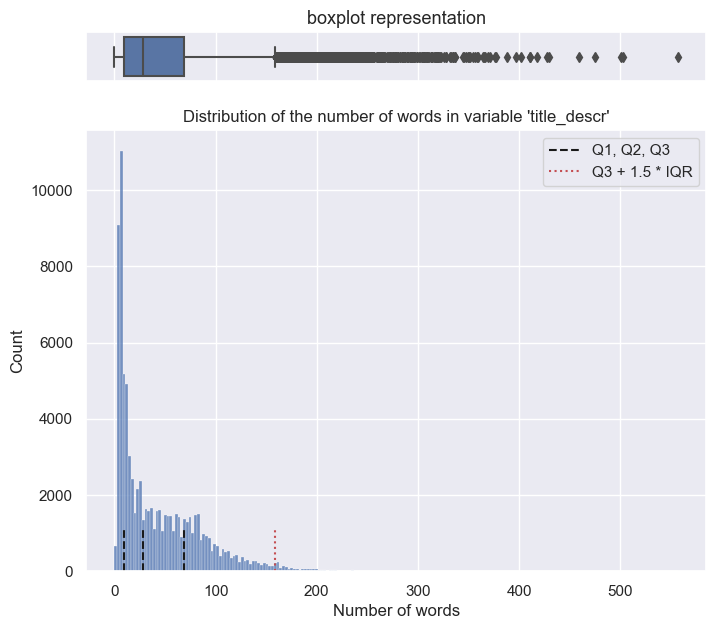

In [307]:
# quantile values
q1, q2, q3 = df['text_token_len'].quantile(q=[0.25,0.5,0.75])
iqr = q3-q1

# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
fsize = 14



fig, (ax_box, ax_hist) = plt.subplots(2, figsize = (8,7), sharex=True, gridspec_kw={"height_ratios": (.1, .9)})
plt.title("Distribution of the number of words in variable 'title_descr'")#, fontsize = fsize)

## Box plot
sns.boxplot(x = df.text_token_len, ax = ax_box)
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set_title('boxplot representation', fontsize = 13)
## hist plot

sns.histplot(x = df.text_token_len, ax = ax_hist)#, kde = True

# add quantiles and extreme values markers
ax_hist.axvline(x=q1, ymin= 0, ymax = 0.1, c='k', ls = '--', label='Q1, Q2, Q3')
ax_hist.axvline(x=q2, ymin= 0, ymax = 0.1, c='k', ls = '--')
ax_hist.axvline(x=q3, ymin= 0, ymax = 0.1, c='k', ls = '--')
ax_hist.axvline(x=q3+1.5*iqr, ymin= 0, ymax = 0.1, c='r', ls = ':', label='Q3 + 1.5 * IQR')
ax_hist.legend()

plt.xlabel('Number of words')
#plt.xlim([0,500])
#plt.ylim([0,10])
plt.show()